In [1]:
## To Do:

# Add a logging function to track use of files for input and output with timestamps

<div class="alert alert-block alert-success">
A green text box indicates a code cell that must be run, without alteration, to complete the workflow.
</div>

<div class="alert alert-block alert-warning">
An orange text box indicates an optional code cell that doesn't have to be run to complete the workflow, but can be run to complete optional tasks.
</div>

<div class="alert alert-block alert-info">
A blue text box indicates a code cell that requires user input - this cell also must be run to complete the workflow, but the user needs to modify the command in the cell.
</div>

<div class="alert alert-block alert-danger">
In addition, some text boxes contain particularly important information. These will be coloured red.
</div>

# <span style="color:green"> Import python functions </sapan>
<div class="alert alert-block alert-success">
    These packages should all be installed and available in your default environment. eResearch can help with installing modules and setting up environments. 
</div>


In [2]:
import os
# import time

# import scipy
import numpy as np
import pandas as pd
import scipy as scipy
import matplotlib.pyplot as plt
import itertools as itertools

from copy import copy as copy
from openpyxl import load_workbook
# from collections import Counter as cnt
# from scipy import stats as stats

import ipywidgets as widgets
# from IPython.display import clear_output



# <span style="color:green"> Define/Import custom functions </sapan>
<div class="alert alert-block alert-success">
    Custom functions for this workflow are imported from the functions folder. 
</div>

In [3]:
from functions.masterdata import (
        master_data, 
        read_Surf_Areas, 
        readConfig, 
        make_locate_list, 
        enter_locations, 
        read_plate_info,
        getUniqueCombos,
        check_plate_info,
        infer_plate_info)

from functions.plotting import (
        plot_SA_Hist, 
        draw_probe_plot, 
        probe_GeoMean_Plots, 
        threshold_probes, 
        get_colour_mapping, 
        binding_density_plot
    )


# <span style="color:orange"> Configure output options for this run </span>

<div class="alert alert-block alert-warning">
    The writeOutput variable below enables high level control for whether output files are written. This can be turned off to prevent overwriting existing files. <br>
    AutoRunProject allows the selection of a folder location from a projects.txt config file
</div>

In [87]:
writeOutput = True
# writeOutput = False

autoRunProject = True
autoRunProject = False


## <span style="color:blue"> Read in config file </sapan>
<div class="alert alert-block alert-info">
    If running in autoRunProject mode, a project.txt file is used to hold all current projects, with one project per line. Inactive projects or comment lines start with a #. The project to run must be uncommented.<br>
A config file (config.txt) or project file (project.txt) must be present in the folder given in the projects file or can be entered in the text below.
</div>

In [88]:
if autoRunProject:
    with open('projects.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if ((not line.startswith('#')) and (not line.strip()=='')):
                subfolder = line
else:
    subfolder = input("Enter the name of the working folder (Must be same level as code folder)")

print(subfolder)
os.chdir("../" + subfolder)


Enter the name of the working folder (Must be same level as code folder) Batra_EOI


Batra_EOI


In [6]:
configDict = readConfig()

projectName  :  Batra_EOI
rootDir  :  /Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/
initialDataPath  :  Initial Dataset.xlsx
QCDataPath  :  Default_QC.xlsx
labWorksheet01Path  :  Lab_Worksheet_P1001660008734A.txt
sampleInfoFile  :  sampleInfo_with_Wells.csv
selectedData  :  Col, Row
probeThresholdIdx  :  32


# <span style="color:green"> Import data from Nanostring initial_dataset file </sapan>
<div class="alert alert-block alert-success">
    Initial dataset.xlsx file must be located in the folder specified as rootDir above.
</div>

In [7]:
dataPath = os.path.join(configDict['rootDir'],configDict['initialDataPath'])
print(f'dataPath : {dataPath}\n')

masterData = master_data(dataPath)
# Read in masterr data and clean sample names.
dataExternal, dataLog1External, sampleInfo = masterData.get_data(fix_zeros=True, clean_names=True)
dataLog1External, sampleInfo = masterData.add_class_mean(masterData.dataLog1)
nuclei = sampleInfo.loc['AOI nuclei count']
surfArea = sampleInfo.loc['AOI surface area']


dataPath : /Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/Initial Dataset.xlsx

Positive Control count:	1, ['HYB-POS']
Nagative Control count:	4, ['HYB-NEG', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1']
Ig Control count:	3, ['Rb IgG', 'Ms IgG2a', 'Ms IgG1']
HK Control count:	3, ['S6', 'Histone H3', 'GAPDH']
Endogenous probe count:	63, ['CD8', 'CD4', 'GZMB', 'Fibronectin', 'Beta-2-microglobulin', 'PD-1', 'HLA-DR', 'CD3', 'CD56', 'CD11c', 'CTLA4', 'CD68', 'PanCk', 'SMA', 'CD20', 'PD-L1', 'CD45', 'Ki-67', 'CD25', 'ICOS', 'CD80', 'CD27', 'PD-L2', 'CD127', 'CD40', 'CD44', 'IDO1', 'Tim-3', '4-1BB', 'STING', 'GITR', 'OX40L', 'VISTA', 'B7-H3', 'LAG3', 'ARG1', 'GZMA', 'PARP', 'CD95/Fas', 'p53', 'Cleaved Caspase 9', 'BAD', 'BCL6', 'BCLXL', 'BIM', 'PTEN', 'EpCAM', 'Her2', 'S100B', 'Bcl-2', 'NY-ESO-1', 'PR', 'MART1', 'ER-alpha', 'MET', 'INPP4B', 'PLCG1', 'Phospho-GSK3A (S21)/Phospho-GSK3B (S9)', 'Phospho-Tuberin (T1462)', 'Phospho-AKT1 (S473)', 'Pan-AKT', 'Phospho-PRAS40 (T246)', 'Phos

/Users/upton6/anaconda3/envs/nanoeda/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# <span style="color:blue"> Infer the sample locations on the processing plates </sapan>
<div class="alert alert-block alert-info">
    The locations of each individual sample on the processing plates can be inferred from the labworksheet files. Place this file in the rootDir location. If all AOIs have a unique surface area the script should identify the location of each sample automatically. If samples have identical surface areas, sample plate and well (col and row coordinates) will need to be input manually when prompted below.

    NOTE: if samples are re-named or new features are added, the sampleInfoWithWells files should be deleted or manually updated.
</div>

In [8]:
# ToDo: Update master sample info to include plate and well info    !!!!!!!!!!

In [9]:
infoPath = os.path.join(configDict['rootDir'], configDict['sampleInfoFile'])

worksheets = [configDict[x].split(',') for x in configDict.keys() if x.startswith('labWorksheet')]
worksheets = list(itertools.chain(*worksheets))

if os.path.isfile(infoPath):
    print(f'reading plate info from file : {infoPath}')
    sampleInfo = read_plate_info(masterData, infoPath)
    masterData.sampleInfo = sampleInfo
    writePlateInfoOutput = False
else:
    print('inferring plate info')
    sampleInfo = infer_plate_info(sampleInfo ,configDict['rootDir'], worksheets)
    masterData.sampleInfo = sampleInfo
    writePlateInfoOutput = True
    
plateInfoComplete = check_plate_info(sampleInfo)

while not(plateInfoComplete):
    print('completing plate info')
    sampleInfo = infer_plate_info(sampleInfo ,configDict['rootDir'], worksheets)
    masterData.sampleInfo = sampleInfo
    writePlateInfoOutput = True
    plateInfoComplete = check_plate_info(sampleInfo)

## Write sample info with well data included to file:
if writePlateInfoOutput:
    sampleInfo.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'sampleInfo_with_wells.csv'))

    
# ToDo: Check whether sampleInfo has been updated in masterData

reading plate info from file : /Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/sampleInfo_with_Wells.csv


In [10]:
# Check if any values for weill, row, col or plate are blank
sampleInfo.loc[['Well','Row','Col','Plate']].isnull().any().any()

False

In [11]:
# Sanity check
# View sampleInfo entries for weill, row, col or plate
sampleInfo.loc[['Well','Row','Col','Plate']]

X24_008_3_4_5um_QUT_TMA3_001_Tumour X24_008_3_4_5um_QUT_TMA3_002_TME  \
Well                                  D07                              D08   
Row                                     D                                D   
Col                                    07                               08   
Plate                                   1                                1   

      X24_008_3_4_5um_QUT_TMA3_002_Tumour X24_008_3_4_5um_QUT_TMA3_003_TME  \
Well                                  D09                              D10   
Row                                     D                                D   
Col                                    09                               10   
Plate                                   1                                1   

      X24_008_3_4_5um_QUT_TMA3_003_Tumour X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
Well                                  D11                                 D12   
Row                                     D                                   D   
Col                                    11                                  12   
Plate                                   1                                   1   

      X24_008_3_4_5um_QUT_TMA3_005_TME X24_008_3_4_5um_QUT_TMA3_005_Tumour  \
Well                               E01                                 E02   
Row                                  E                                   E   
Col                                 01                                  02   
Plate                                1                                   1   

      X24_008_3_4_5um_QUT_TMA3_006_TME X24_008_3_4_5um_QUT_TMA3_006_Tumour  \
Well                               E03                                 E04   
Row                                  E                                   E   
Col                                 03                                  04   
Plate                                1                                   1   

       ... X24_008_3_4_5um_QUT_TMA1_025_TME  \
Well   ...                              C09   
Row    ...                                C   
Col    ...                               09   
Plate  ...                                1   

      X24_008_3_4_5um_QUT_TMA1_025_Tumour X24_008_3_4_5um_QUT_TMA1_028_TME  \
Well                                  C10                              C11   
Row                                     C                                C   
Col                                    10                               11   
Plate                                   1                                1   

      X24_008_3_4_5um_QUT_TMA1_028_Tumour X24_008_3_4_5um_QUT_TMA1_029_Tumour  \
Well                                  C12                                 D01   
Row                                     C                                   D   
Col                                    12                                  01   
Plate                                   1                                   1   

      X24_008_3_4_5um_QUT_TMA1_031_Tumour X24_008_3_4_5um_QUT_TMA1_032_Tumour  \
Well                                  D02                                 D03   
Row                                     D                                   D   
Col                                    02                                  03   
Plate                                   1                                   1   

      X24_008_3_4_5um_QUT_TMA1_034_Tumour X24_008_3_4_5um_QUT_TMA1_038_TME  \
Well                                  D04                              D05   
Row                                     D                                D   
Col                                    04                               05   
Plate                                   1                                1   

      X24_008_3_4_5um_QUT_TMA1_038_Tumour  
Well                                  D06  
Row                                     D  
Col                                    06  
Plate                         

# <span style="color:green"> Basic QC and data overview plots </sapan>
<div class="alert alert-block alert-success">
    The cells below output basic QC plots to start getting a look at and feel for the data. 
</div>


## <span style="color:orange"> Choose factors of interest for data visualisation </span>

<div class="alert alert-block alert-warning">
Select factors to use for data visualisation. These factors will be used to generate colour mappings for plotting data. <br>
    Re-running the checkbox generation cell below will clear selections and generate empty checkboxes.
</div>

In [12]:
# ToDo: Check if selected data is written to config file
# If written already, use this by default, otherwise ask for selection

<i>INFO: The input cell does not advance to the next cell. Run the first cell below to generate the checkboxes, then select checkboxes and run the second cell below to read the selected checkboxes. Re-running the first cell below will clear selections and generate empty checkboxes.</i>

In [13]:
# input("Press Enter to continue and choose factors of interest via the checkboxes generated in the next cell.")

In [14]:
# checkbox generation cell 

# if (len(configDict['selectedData']) == 0):

data = list(sampleInfo.index)
checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
output = widgets.VBox(children=checkboxes)
display(output)

In [15]:
# Write configDict['selectedData'] to config.txt file
# if (len(configDict['selectedData']) == 0):
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        if not ([checkboxes[i].description] in configDict['selectedData']):
            configDict['selectedData'] = configDict['selectedData'] + [checkboxes[i].description]
print('configDict[selectedData] :\t{}'.format(configDict['selectedData']))
print('length : {}'.format(len(configDict['selectedData'])))

configDict[selectedData] :	['Col', 'Row']
length : 2


<div class="alert alert-block alert-warning">
To write selected factors to the config file, set newConfig to true in the cell below. Make sure the config file contains a single selectedData line after running this.
</div>

In [16]:
# ToDo: update to determine whether a new config has been added and should be written to config.txt. Perhaps write a final version of the config file once whole script has been run.
# newConfig = True
newConfig = False
if newConfig:
    with open('config.txt', 'a') as config:
        config.write('selectedData : ')
        config.write(', '.join([x.description for x in checkboxes if x.value == True]))
        config.write('\n')



### <span style="color:green"> Unique factor variable name check </sapan>
<div class="alert alert-block alert-success">
    Quick check that variable names are entered correctly. 
</div>

<div class="alert alert-block alert-danger">
Using clean and consistent data is essential for correctly selecting sample groups for analysis. This section is designed to identify the unique variables that have been entered for each factor of interest at the sample annotation stage. Please review the factor variables carefuly to make sure that all expected variables are present, and there are no unexpected variations of v ariable names. variables are case sensitive and any differences will generate a unique variable. 
</div>

In [17]:
selectedFactors = configDict['selectedData']
print(selectedFactors)
selectedFactors.extend(['Row', 'Col'])
print(selectedFactors)
selectedFactors = list(set(selectedFactors))
configDict['selectedData'] = selectedFactors.copy()

selectedInfo = sampleInfo.loc[selectedFactors]
selectedInfo = selectedInfo.fillna(value='AutoFilledBlank')
# selectedInfo.drop_duplicates(keep='first', inplace=True)
selectedInfo

['Col', 'Row']
['Col', 'Row', 'Row', 'Col']


X24_008_3_4_5um_QUT_TMA3_001_Tumour X24_008_3_4_5um_QUT_TMA3_002_TME  \
Col                                  07                               08   
Row                                   D                                D   

    X24_008_3_4_5um_QUT_TMA3_002_Tumour X24_008_3_4_5um_QUT_TMA3_003_TME  \
Col                                  09                               10   
Row                                   D                                D   

    X24_008_3_4_5um_QUT_TMA3_003_Tumour X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
Col                                  11                                  12   
Row                                   D                                   D   

    X24_008_3_4_5um_QUT_TMA3_005_TME X24_008_3_4_5um_QUT_TMA3_005_Tumour  \
Col                               01                                  02   
Row                                E                                   E   

    X24_008_3_4_5um_QUT_TMA3_006_TME X24_008_3_4_5um_QUT_TMA3_006_Tumour  ...  \
Col                               03                                  04  ...   
Row                                E                                   E  ...   

    X24_008_3_4_5um_QUT_TMA1_025_TME X24_008_3_4_5um_QUT_TMA1_025_Tumour  \
Col                               09                                  10   
Row                                C                                   C   

    X24_008_3_4_5um_QUT_TMA1_028_TME X24_008_3_4_5um_QUT_TMA1_028_Tumour  \
Col                               11                                  12   
Row                                C                                   C   

    X24_008_3_4_5um_QUT_TMA1_029_Tumour X24_008_3_4_5um_QUT_TMA1_031_Tumour  \
Col                                  01                                  02   
Row                                   D                                   D   

    X24_008_3_4_5um_QUT_TMA1_032_Tumour X24_008_3_4_5um_QUT_TMA1_034_Tumour  \
Col                                  03                                  04   
Row                                   D                                   D   

    X24_008_3_4_5um_QUT_TMA1_038_TME X24_008_3_4_5um_QUT_TMA1_038_Tumour  
Col                               05                                  06  
Row                                D                                   D  

[2 rows x 96 columns]

In [18]:
# Unique factor variables are printed below

infoValues = selectedInfo.stack().groupby(level=0).apply(lambda x: sorted(x.unique()))
infoValues

Col    [01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12]
Row                            [A, B, C, D, E, F, G, H]
dtype: object

#### factors unique combinations table

In [19]:
# infoValues = pd.DataFrame(infoValues).T

# # ToDo: Break lists down into separate rows

# infoValues.style.set_table_styles(
#                         [{
# 'selector': 'th',
#    'props': [
# ('background-color', 'black'),
#        ('color', 'white'),
#        ('border-color', 'black'),
#        ('border-style ', 'solid'),
#        ('border-width','1px')]  
# },
# {
#    'selector': 'td',
#    'props': [
#        ('border-color', 'black'),
#        ('border-style ', 'solid'),
#        ('border-width','1px')]
# },
# {'selector': '.row_heading',
#       'props': [('display', 'none')]},
# {'selector': '.blank.level0',
#       'props': [('display', 'none')]}])

In [20]:
getUniqueCombos(selectedInfo)


Number of unique combinations: 96


['01_A',
 '01_B',
 '01_C',
 '01_D',
 '01_E',
 '01_F',
 '01_G',
 '01_H',
 '02_A',
 '02_B',
 '02_C',
 '02_D',
 '02_E',
 '02_F',
 '02_G',
 '02_H',
 '03_A',
 '03_B',
 '03_C',
 '03_D',
 '03_E',
 '03_F',
 '03_G',
 '03_H',
 '04_A',
 '04_B',
 '04_C',
 '04_D',
 '04_E',
 '04_F',
 '04_G',
 '04_H',
 '05_A',
 '05_B',
 '05_C',
 '05_D',
 '05_E',
 '05_F',
 '05_G',
 '05_H',
 '06_A',
 '06_B',
 '06_C',
 '06_D',
 '06_E',
 '06_F',
 '06_G',
 '06_H',
 '07_A',
 '07_B',
 '07_C',
 '07_D',
 '07_E',
 '07_F',
 '07_G',
 '07_H',
 '08_A',
 '08_B',
 '08_C',
 '08_D',
 '08_E',
 '08_F',
 '08_G',
 '08_H',
 '09_A',
 '09_B',
 '09_C',
 '09_D',
 '09_E',
 '09_F',
 '09_G',
 '09_H',
 '10_A',
 '10_B',
 '10_C',
 '10_D',
 '10_E',
 '10_F',
 '10_G',
 '10_H',
 '11_A',
 '11_B',
 '11_C',
 '11_D',
 '11_E',
 '11_F',
 '11_G',
 '11_H',
 '12_A',
 '12_B',
 '12_C',
 '12_D',
 '12_E',
 '12_F',
 '12_G',
 '12_H']

In [21]:
# ToDo: Add in functionality to view number of samples in different subgroups

## <span style="color:green"> Write Factor lookup csv file </sapan>
<div class="alert alert-block alert-success">
    Quick check that variable names are entered correctly. 
</div>


In [22]:
# Check the current working directory. Should be folder for config files etc.

os.getcwd()

'/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/Batra_EOI'

In [23]:
with open('factor_lookup.tsv', 'w') as f:
    for idx in infoValues.index:
        f.write(idx)
        f.write(': ')
        f.write('\t'.join(infoValues[idx]))
        f.write('\n')

# factor: variable1, variable2

## <span style="color:orange"> Choose factors to use for colour selection in the plots below </sapan>

<div class="alert alert-block alert-warning">
Use the cell below to select the factors to use for colour map generation in some of the figures below.<br><br>
Set re-select to True to select new factors, or False to continue with current selection.
</div>

In [24]:
# selected_data = []
reselect = True
reselect = False

if reselect:
    print('reselecting')
    data = list(selectedInfo.index)
    checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
    output = widgets.VBox(children=checkboxes)
    display(output)

In [25]:
if reselect:
    print('reselecting')
    for i in range(0, len(checkboxes)):
        if checkboxes[i].value == True:
            configDict['selectedData'] = configDict['selectedData'] + [checkboxes[i].description]
    print(configDict['selectedData'])


In [26]:
selectedInfo = selectedInfo.loc[configDict['selectedData']]
selectedInfo

X24_008_3_4_5um_QUT_TMA3_001_Tumour X24_008_3_4_5um_QUT_TMA3_002_TME  \
Col                                  07                               08   
Row                                   D                                D   

    X24_008_3_4_5um_QUT_TMA3_002_Tumour X24_008_3_4_5um_QUT_TMA3_003_TME  \
Col                                  09                               10   
Row                                   D                                D   

    X24_008_3_4_5um_QUT_TMA3_003_Tumour X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
Col                                  11                                  12   
Row                                   D                                   D   

    X24_008_3_4_5um_QUT_TMA3_005_TME X24_008_3_4_5um_QUT_TMA3_005_Tumour  \
Col                               01                                  02   
Row                                E                                   E   

    X24_008_3_4_5um_QUT_TMA3_006_TME X24_008_3_4_5um_QUT_TMA3_006_Tumour  ...  \
Col                               03                                  04  ...   
Row                                E                                   E  ...   

    X24_008_3_4_5um_QUT_TMA1_025_TME X24_008_3_4_5um_QUT_TMA1_025_Tumour  \
Col                               09                                  10   
Row                                C                                   C   

    X24_008_3_4_5um_QUT_TMA1_028_TME X24_008_3_4_5um_QUT_TMA1_028_Tumour  \
Col                               11                                  12   
Row                                C                                   C   

    X24_008_3_4_5um_QUT_TMA1_029_Tumour X24_008_3_4_5um_QUT_TMA1_031_Tumour  \
Col                                  01                                  02   
Row                                   D                                   D   

    X24_008_3_4_5um_QUT_TMA1_032_Tumour X24_008_3_4_5um_QUT_TMA1_034_Tumour  \
Col                                  03                                  04   
Row                                   D                                   D   

    X24_008_3_4_5um_QUT_TMA1_038_TME X24_008_3_4_5um_QUT_TMA1_038_Tumour  
Col                               05                                  06  
Row                                D                                   D  

[2 rows x 96 columns]

In [27]:
configDict['selectedData']

['Col', 'Row']

In [28]:
configDict['selectedData']

['Col', 'Row']

ToDo: Add colour lookup dictionary

## <span style="color:green"> Plot distribution of AOI surface areas </sapan>
<div class="alert alert-block alert-success">
    Ideally, the AOI seze can be kept the same for all AOIs, however this is likely impossible or impractical for most studies. Here we plot the distribution of AOI sizes to get a clear view the different AOI sizes present in our data set. This may become important in later steps when deciding on normalisation approaches, data thresholding and exclusion of outlier AOIs. 
</div>


Min SA : 6688.835244
Max SA : 197186.672969


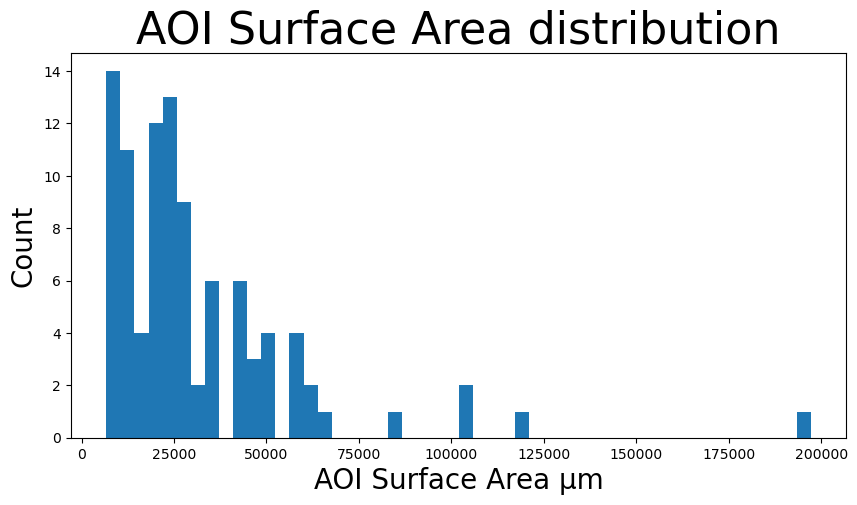

In [29]:
# ToDo: Add colouring for different AOI types
SAHist = plot_SA_Hist(surfArea)


## <span style="color:green"> Plot Binding Density histograms (in plate order) </sapan>
<div class="alert alert-block alert-success">
Binding density is calculated per lane on the nCounter cartridge. This is equivalent to the columns on hte hybridisation plate. The binding density should be similar, but does not need to be exactly the same.
</div>


Number of unique combinations: 96


/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/DSP_EDA_Protein/functions/plotting.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')


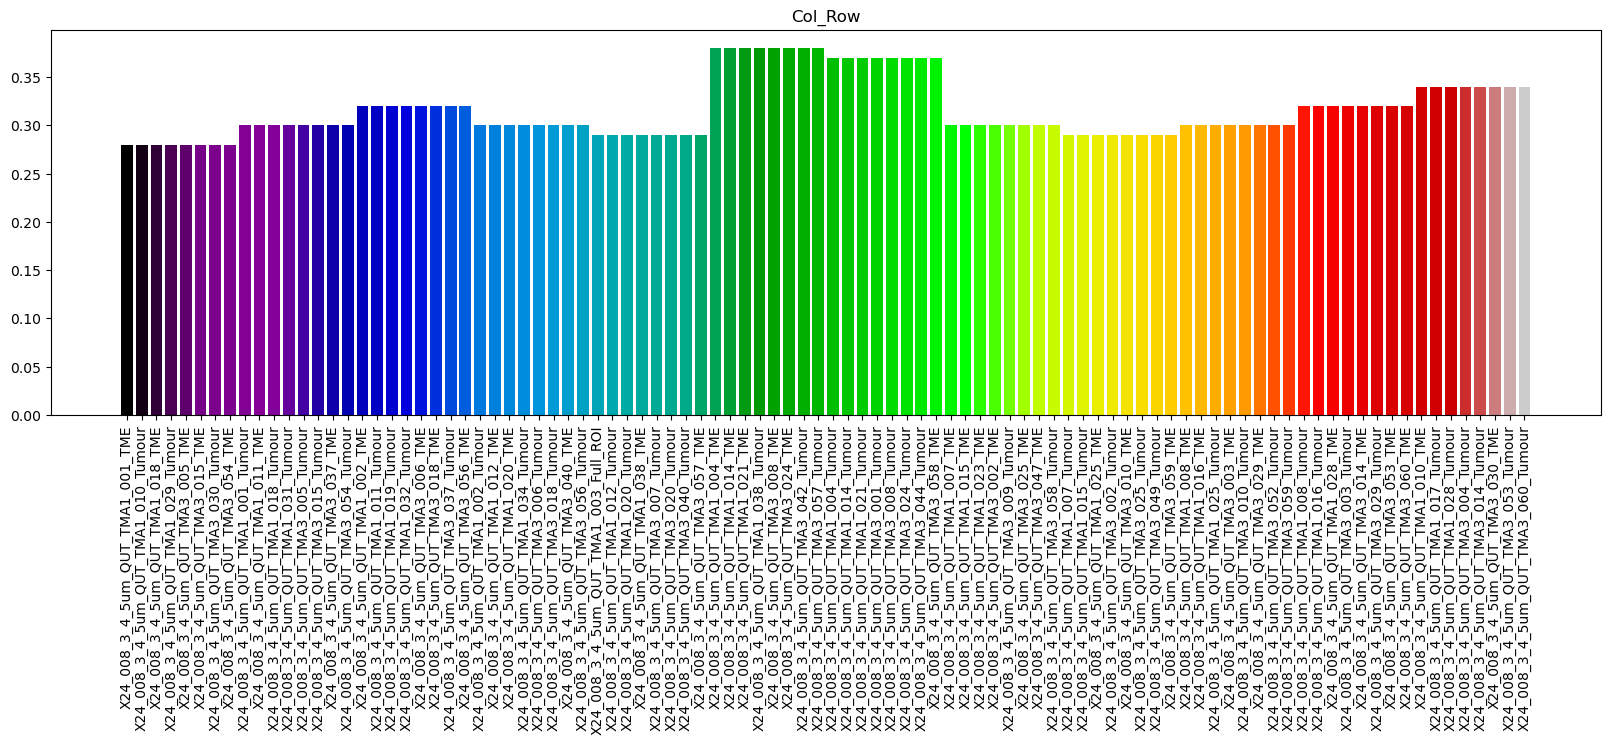


Number of unique combinations: 12


/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/DSP_EDA_Protein/functions/plotting.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')


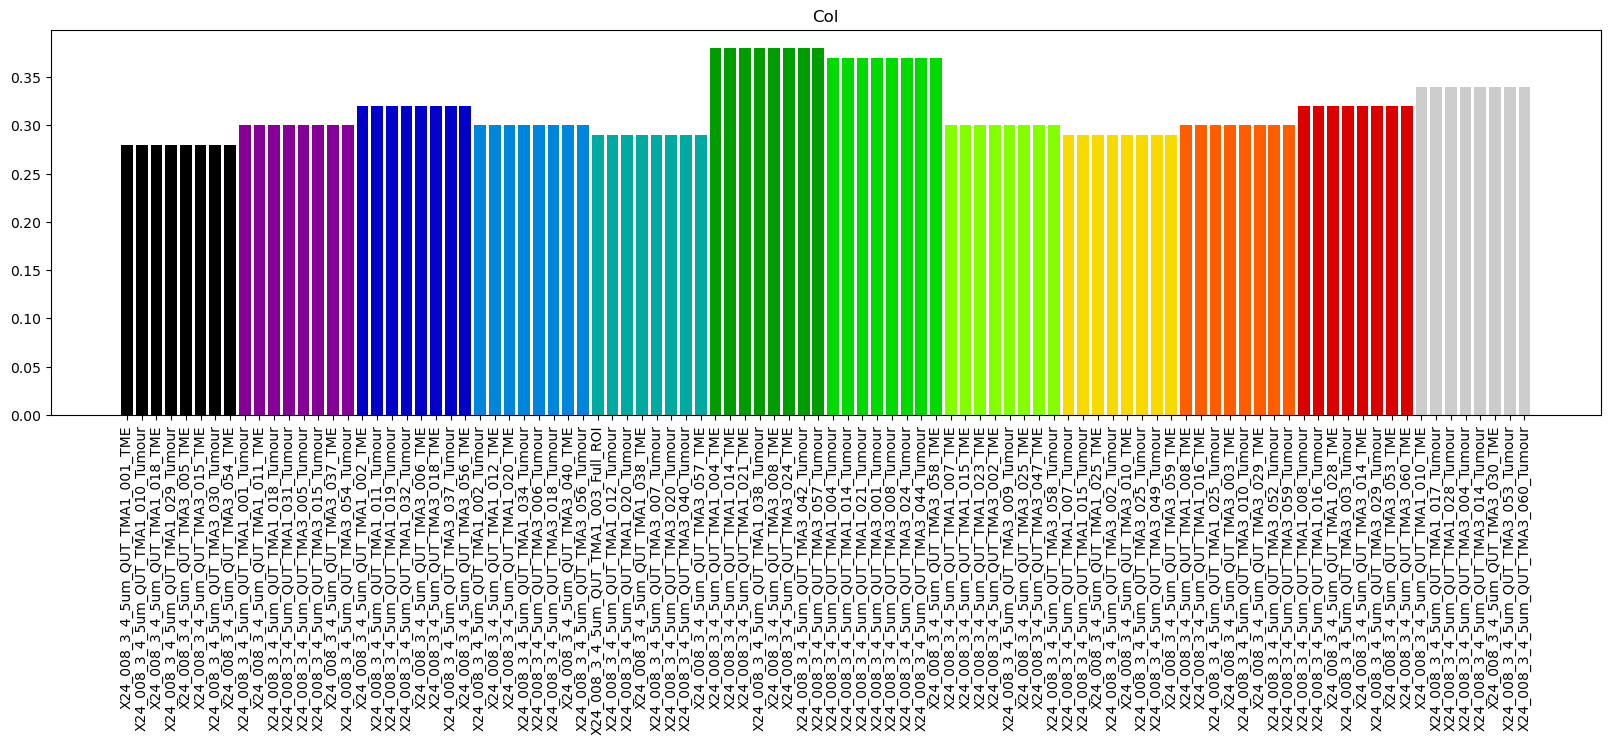


Number of unique combinations: 8


/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/DSP_EDA_Protein/functions/plotting.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')


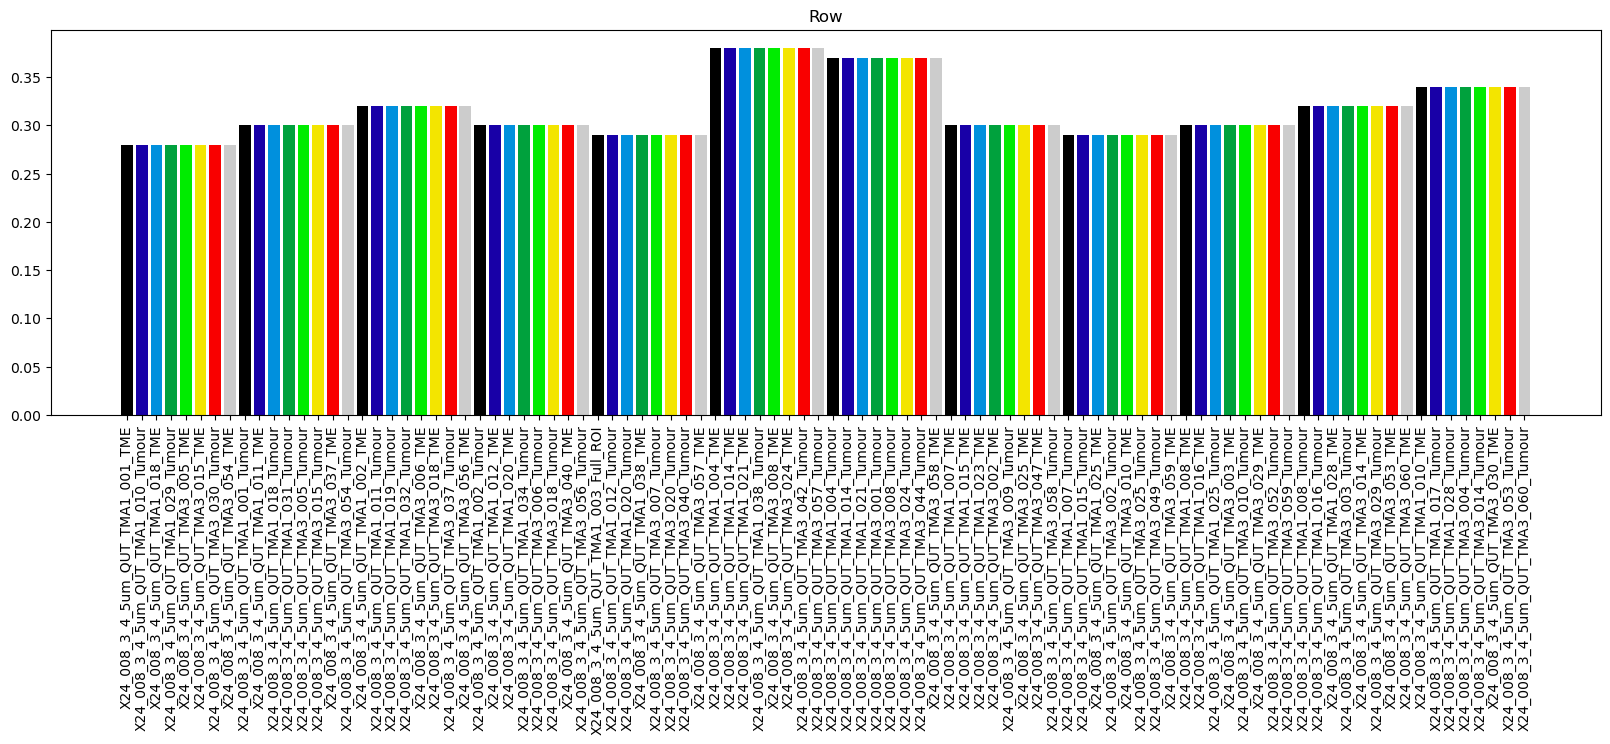

In [30]:
# generate binding density plots

binding_density_plot(sampleInfo, selectedInfo, configDict['selectedData'])
# binding_density_plot(sampleInfo, selectedInfo, 'Col')

for s in selectedFactors:
    binding_density_plot(sampleInfo, selectedInfo, s)
    

## <span style="color:green"> Visualise raw probe values before any normalisation </sapan>
<div class="alert alert-block alert-success">
Checking the raw probe values can help identify any systemic issues that may be present in the data set.
</div>

<div class="alert alert-block alert-danger">
The plots below are aranged with the individual probes on the x axis and probe count on the y axis. each sample is represented by a dot for the probe value for each probe.
</div>

In [31]:
# Show the selected data rows that are currently selected
print('configDict[\'selectedData\'] :\t' + str(configDict['selectedData']))

configDict['selectedData'] :	['Col', 'Row']


In [32]:
# Show some of the log transformed data to be plotted
dataLog1External

X24_008_3_4_5um_QUT_TMA3_001_Tumour  \
CD8                                                 6.862024   
CD4                                                 7.712544   
HYB-NEG                                             1.000000   
GZMB                                                7.615952   
Fibronectin                                        10.169188   
...                                                      ...   
Phospho-Tuberin (T1462)                             2.021181   
Phospho-AKT1 (S473)                                 4.225166   
Pan-AKT                                             8.544534   
Phospho-PRAS40 (T246)                               3.151620   
Phospho-GSK3B (S9)                                  1.898987   

                         X24_008_3_4_5um_QUT_TMA3_002_TME  \
CD8                                              4.039610   
CD4                                              4.519728   
HYB-NEG                                          0.000000   
GZMB                                             2.902034   
Fibronectin                                      8.150352   
...                                                   ...   
Phospho-Tuberin (T1462)                          1.014155   
Phospho-AKT1 (S473)                              1.819236   
Pan-AKT                                          4.357326   
Phospho-PRAS40 (T246)                            0.000000   
Phospho-GSK3B (S9)                               0.933450   

                         X24_008_3_4_5um_QUT_TMA3_002_Tumour  \
CD8                                                 5.398750   
CD4                                                 5.845727   
HYB-NEG                                             0.000000   
GZMB                                                4.285359   
Fibronectin                                         8.063207   
...                                                      ...   
Phospho-Tuberin (T1462)                             0.000000   
Phospho-AKT1 (S473)                                 2.872308   
Pan-AKT                                             4.719502   
Phospho-PRAS40 (T246)                               2.461158   
Phospho-GSK3B (S9)                                  2.691316   

                         X24_008_3_4_5um_QUT_TMA3_003_TME  \
CD8                                              7.097183   
CD4                                              7.775182   
HYB-NEG                                          0.000000   
GZMB                                             5.533675   
Fibronectin                                     11.618742   
...                                                   ...   
Phospho-Tuberin (T1462)                          2.608478   
Phospho-AKT1 (S473)                              3.898129   
Pan-AKT                                          5.821859   
Phospho-PRAS40 (T246)                            2.130911   
Phospho-GSK3B (S9)                               2.213922   

                         X24_008_3_4_5um_QUT_TMA3_003_Tumour  \
CD8                                                 5.595916   
CD4                                                 6.090568   
HYB-NEG                                             0.000000   
GZMB                                                4.891132   
Fibronectin                                         9.947540   
...                                                      ...   
Phospho-Tuberin (T1462)                             1.014155   
Phospho-AKT1 (S473)                                 3.770270   
Pan-AKT                                             6.113507   
Phospho-PRAS40 (T246)                               1.088580   
Phospho-GSK3B (S9)                                  2.881442   

                         X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
CD8                                                 6.671149   
CD4                                                 7.175929   
HYB-NEG                                             0.000000


Number of unique combinations: 12

Number of unique combinations: 8


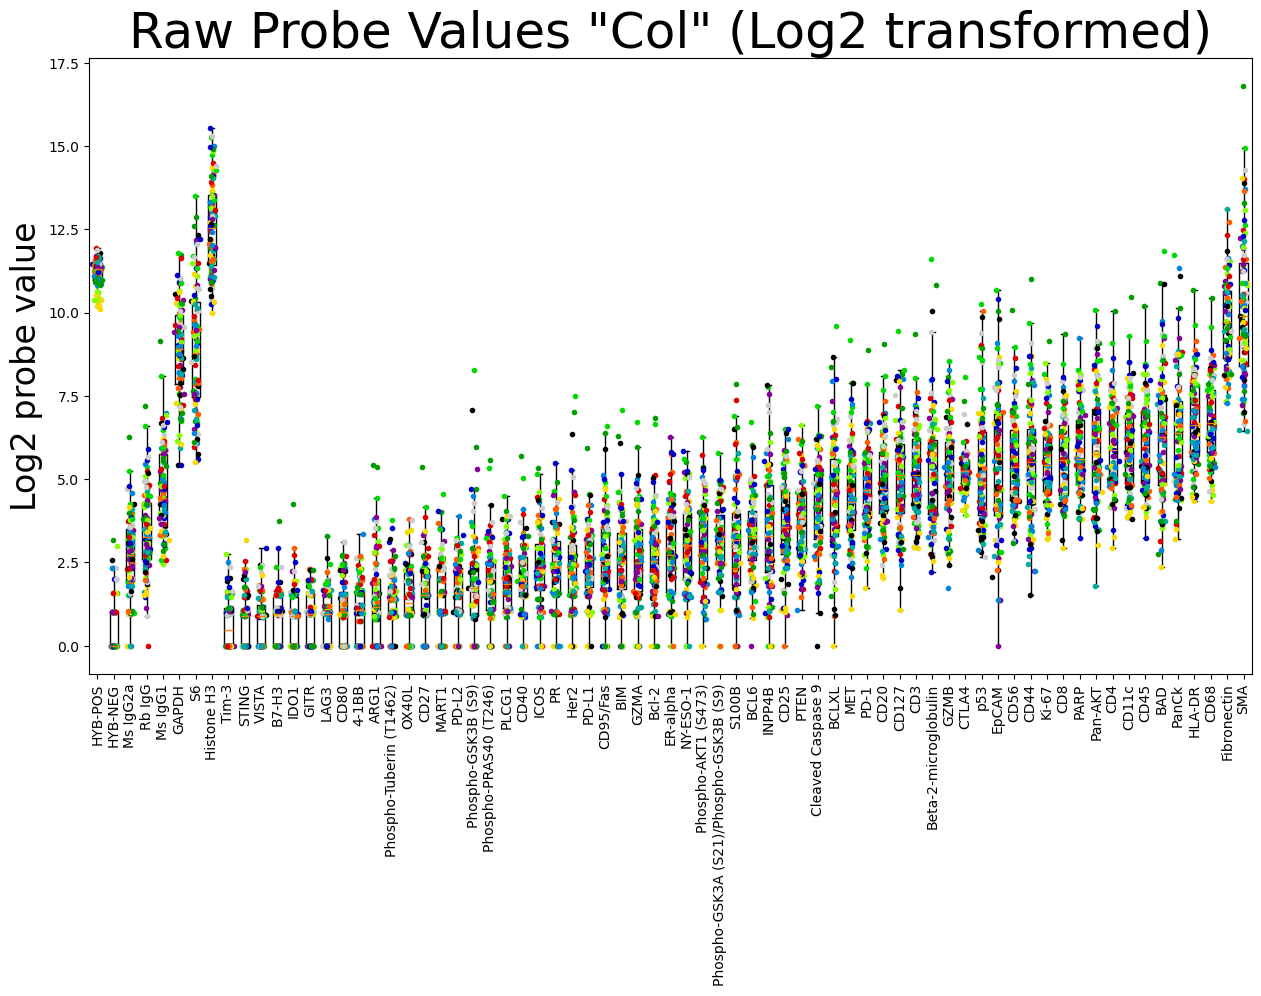

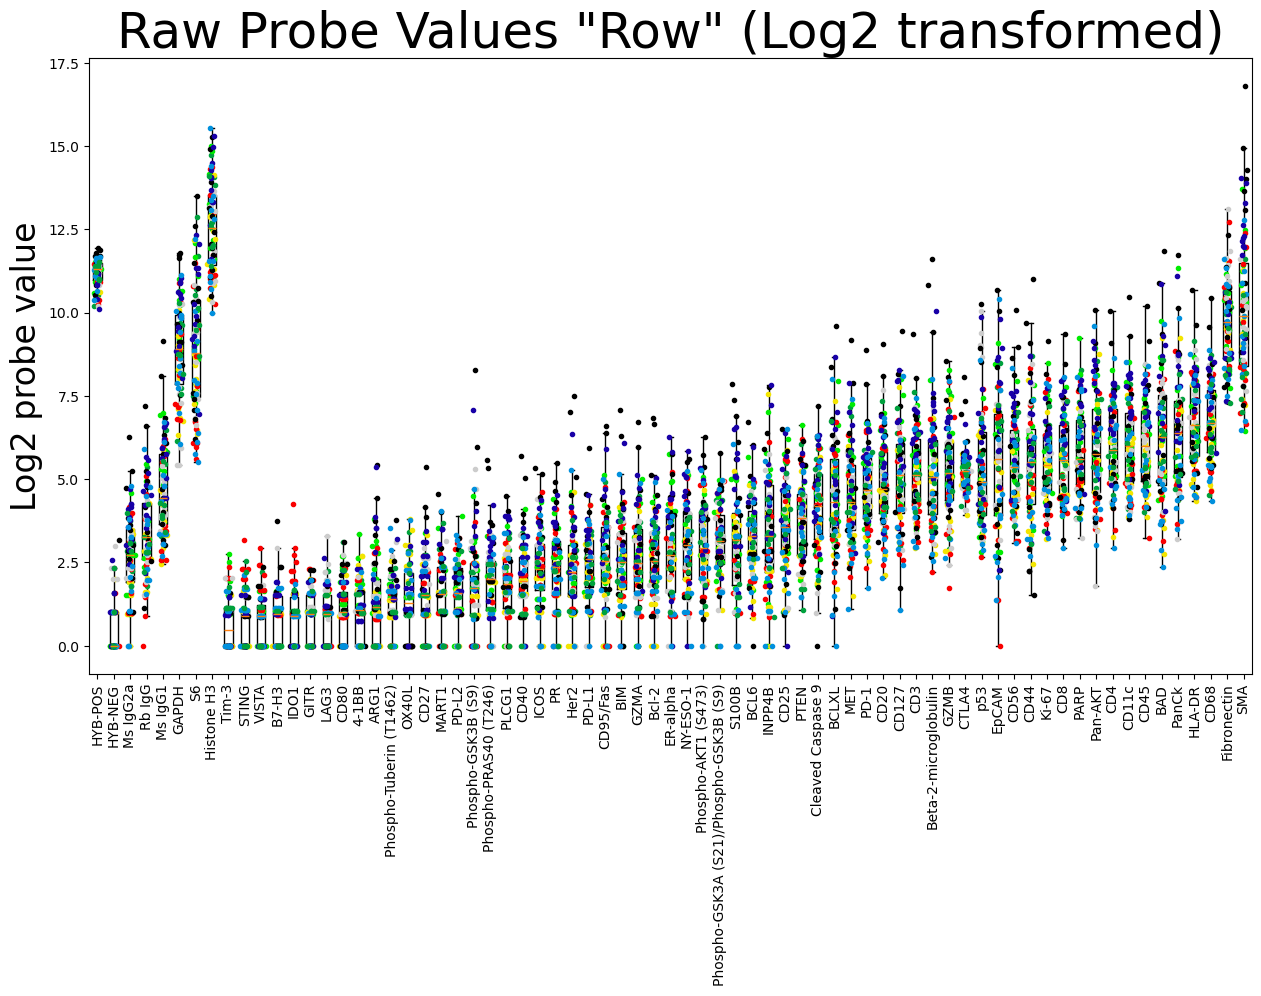

In [33]:
dataSortedRaw = dataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

# for s in configDict['selectedData']:
for s in selectedFactors:
    draw_probe_plot(dataSortedRaw, sampleInfo, selectedInfo, s, 'Raw Probe Values \"' + s + '\"', savefig=os.path.join(os.getcwd(),'probe_Plot.svg'))
    


In [34]:
dataLog1External

X24_008_3_4_5um_QUT_TMA3_001_Tumour  \
CD8                                                 6.862024   
CD4                                                 7.712544   
HYB-NEG                                             1.000000   
GZMB                                                7.615952   
Fibronectin                                        10.169188   
...                                                      ...   
Phospho-Tuberin (T1462)                             2.021181   
Phospho-AKT1 (S473)                                 4.225166   
Pan-AKT                                             8.544534   
Phospho-PRAS40 (T246)                               3.151620   
Phospho-GSK3B (S9)                                  1.898987   

                         X24_008_3_4_5um_QUT_TMA3_002_TME  \
CD8                                              4.039610   
CD4                                              4.519728   
HYB-NEG                                          0.000000   
GZMB                                             2.902034   
Fibronectin                                      8.150352   
...                                                   ...   
Phospho-Tuberin (T1462)                          1.014155   
Phospho-AKT1 (S473)                              1.819236   
Pan-AKT                                          4.357326   
Phospho-PRAS40 (T246)                            0.000000   
Phospho-GSK3B (S9)                               0.933450   

                         X24_008_3_4_5um_QUT_TMA3_002_Tumour  \
CD8                                                 5.398750   
CD4                                                 5.845727   
HYB-NEG                                             0.000000   
GZMB                                                4.285359   
Fibronectin                                         8.063207   
...                                                      ...   
Phospho-Tuberin (T1462)                             0.000000   
Phospho-AKT1 (S473)                                 2.872308   
Pan-AKT                                             4.719502   
Phospho-PRAS40 (T246)                               2.461158   
Phospho-GSK3B (S9)                                  2.691316   

                         X24_008_3_4_5um_QUT_TMA3_003_TME  \
CD8                                              7.097183   
CD4                                              7.775182   
HYB-NEG                                          0.000000   
GZMB                                             5.533675   
Fibronectin                                     11.618742   
...                                                   ...   
Phospho-Tuberin (T1462)                          2.608478   
Phospho-AKT1 (S473)                              3.898129   
Pan-AKT                                          5.821859   
Phospho-PRAS40 (T246)                            2.130911   
Phospho-GSK3B (S9)                               2.213922   

                         X24_008_3_4_5um_QUT_TMA3_003_Tumour  \
CD8                                                 5.595916   
CD4                                                 6.090568   
HYB-NEG                                             0.000000   
GZMB                                                4.891132   
Fibronectin                                         9.947540   
...                                                      ...   
Phospho-Tuberin (T1462)                             1.014155   
Phospho-AKT1 (S473)                                 3.770270   
Pan-AKT                                             6.113507   
Phospho-PRAS40 (T246)                               1.088580   
Phospho-GSK3B (S9)                                  2.881442   

                         X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
CD8                                                 6.671149   
CD4                                                 7.175929   
HYB-NEG                                             0.000000

In [35]:
sampleInfo

X24_008_3_4_5um_QUT_TMA1_001_TME  \
Custom Segment Name                                  24-008_3.4-5um QUT TMA1 | 001 | TME   
ROI                                                 258cd2e4-4699-46b1-aa5f-9ff99e8fff7d   
ROI (Label)                                                                          001   
Segment                                             abb18cd9-3aea-4701-9316-dbca6f1496e6   
Segment (Name/ Label)                                                                TME   
ROI X Coordinate                                                                 38719.0   
ROI Y Coordinate                                                                 84987.0   
Segment Tags                                                                         TME   
AOI                                                                                    1   
AOI surface area                                                                    7822   
AOI nuclei count                                                                    83.0   
Fov count                                                                            555   
Fov counted                                                                          545   
BindingDensity                                                                      0.28   
Scan Name                                                        24-008_3.4-5um QUT TMA1   
Slide                                               54bf97fa-b54a-4efa-a586-e4c1293a37a1   
Scan plexset                                                                           2   
Origin Instrument ID                                                           2001G0086   
#Factor                                                                              NaN   
Scan_ID                                                          24-008_3.4-5um QUT TMA1   
ROI_ID                                                                               001   
LOT_Human_Immune_Cell_Profiling_Protein_Core_1_1                               ICPH10007   
LOT_Human_Immune_Activation_Status_Protein_Modu...                             IASH10003   
LOT_Human_IO_Drug_Target_Protein_Module_1_1                                    DRGH10003   
LOT_Human_nC_Cell_Death_Protein_1_1                                            CLDH10001   
LOT_Human_Pan_Tumor_Protein_Module_1_0                                         PTRH10001   
LOT_Human_PI3K_AKT_Signaling_Protein_Module_1_0                                PKSH10002   
Well                                                                                 A01   
Row                                                                                    A   
Col                                                                                   01   
Plate                                                                                  1   

                                                       X24_008_3_4_5um_QUT_TMA1_010_Tumour  \
Custom Segment Name                                 24-008_3.4-5um QUT TMA1 | 010 | Tumour   
ROI                                                   edf734a5-aedf-4e18-81c3-90fe4768bfb0   
ROI (Label)                                                                            010   
Segment                                               2e06c23f-dbcb-4fb2-8d23-53c35bbb5df9   
Segment (Name/ Label)                                                               Tumour   
ROI X Coordinate                                                                   38853.0   
ROI Y Coordinate                                                                   57815.0   
Segment Tags                                                                        Tumour   
AOI                                                                                      1   
AOI surface area                                                                     44357   
AOI nuclei count                                                             

Text(0, 0.5, 'HYB-POS (Log2 transformed)')

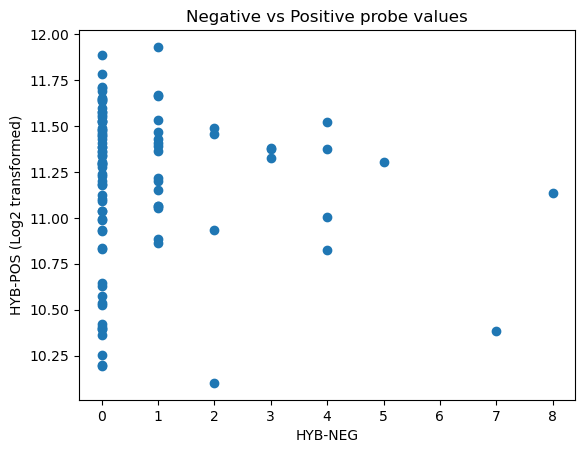

In [36]:
# ToDo: Add cmap for a single factor

# Plot of non-log transformed HYB-NEG values vs log transformed HYB-POS values
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
            dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-POS'])
plt.title('Negative vs Positive probe values')
plt.xlabel('HYB-NEG')
plt.ylabel('HYB-POS (Log2 transformed)')

Text(0, 0.5, 'AOI Surface Area')

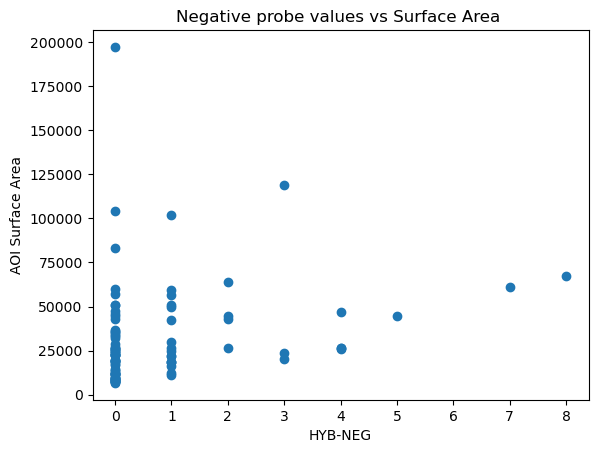

In [37]:
# ToDo: Add cmap for a single factor

# Plot of non-log transformed HYB-NEG values vs AOI surface area values
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
        surfArea.reindex(dataLog1External.drop(labels=['mean','probeClass'],axis=1).columns))
plt.title('Negative probe values vs Surface Area ')
plt.xlabel('HYB-NEG')
plt.ylabel('AOI Surface Area')

## <span style="color:red"> Raw probe QC questions / checks: </sapan>

<div class="alert alert-block alert-danger">
Info on important questions to consider from QC steps
</div>

# <span style="color:orange"> Determine thresholding value for limit of detection for assay </span>

<div class="alert alert-block alert-warning">
In the following section a threshold can be set for primary interrogation of the assay limit of detection and probes and samples that may be usable for further analysis.<br><br>

After running through the following cells and deciding a threshold to use for this study, this threshold can be added to the config file for be automaticcaly imported for future runs.<br><br>

The threshold shoud be set as the first local minimum closest to the start of the 'real' values.


Flesh this documentation out more !!!

</div>

In [38]:
# ToDo: Add plots where hyb-neg and negative controls are shown with separate cmaps

In [39]:
# Try to read in probeThreshold from config file.

try:
    probeThresholdIdx = configDict['probeThresholdIdx']
    probeThresholdSet = True
    print('Previous probe threshold was found')
except KeyError:
    probeThresholdSet = False
    print('No probe threshold was found')


Previous probe threshold was found


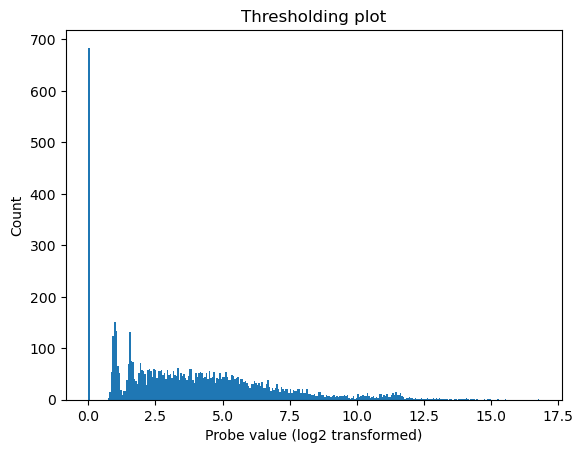

In [40]:
thresholding = threshold_probes(dataLog1External, 300)

In [41]:
#Set index value to use for minimum expression threshold from thresholding.

if not(probeThresholdSet):
    probeThresholdIdx = 38 # Threshold can be set here if it was not read into the configDict

thresholding.set_threshold_idx(probeThresholdIdx)

Threshold index :	32
Threshold count :	31
Threshold point :	 1.794


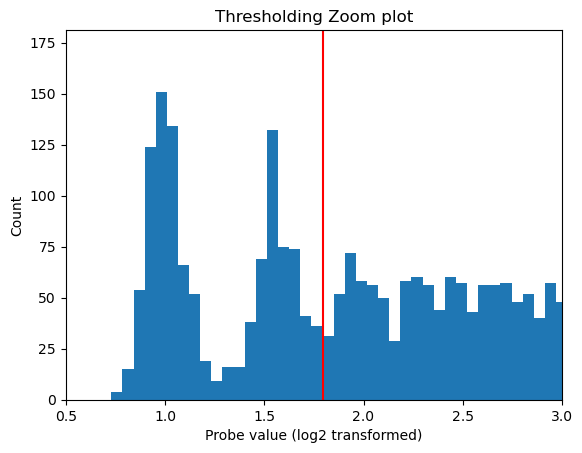

In [42]:
thresholding.zoom_plot(0.5,3)

In [43]:
thresholding.check_threshold(0,50)
thresholding.check_threshold(25,40)

Histogram[0] range :	[684.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.
  15.  54. 124. 151. 134.  66.  52.  19.   9.  16.  16.  38.  69. 132.
  75.  74.  41.  36.  31.  52.  72.  58.  56.  50.  29.  58.  60.  56.
  44.  60.  57.  43.  56.  56.  57.  48.]
Histogram[1] range :	[0.         0.05604788 0.11209576 0.16814363 0.22419152 0.2802394
 0.33628726 0.39233515 0.44838303 0.50443089 0.56047881 0.61652666
 0.67257452 0.72862244 0.78467029 0.84071815 0.89676607 0.95281392
 1.00886178 1.0649097  1.12095761 1.17700541 1.23305333 1.28910124
 1.34514904 1.40119696 1.45724487 1.51329267 1.56934059 1.6253885
 1.6814363  1.73748422 1.79353213 1.84957993 1.90562785 1.96167576
 2.01772356 2.07377148 2.12981939 2.18586731 2.24191523 2.2979629
 2.35401082 2.41005874 2.46610665 2.52215457 2.57820249 2.63425016
 2.69029808 2.746346  ]
Histogram[0] range :	[ 38.  69. 132.  75.  74.  41.  36.  31.  52.  72.  58.  56.  50.  29.
  58.]
Histogram[1] range :	[1.40119696 1.45724487 1.5

In [44]:
thresholding.check_threshold(32,33)


Histogram[0] range :	[31.]
Histogram[1] range :	[1.79353213]


In [45]:
probeThresholdIdx

32

In [46]:
print(f'threshold Index :\t%d'%(probeThresholdIdx))
print(f'threshold point :\t%6.3f'%(thresholding.threshold))
ETFiltered = thresholding.get_filter()

threshold Index :	32
threshold point :	 1.794


In [47]:
if not(probeThresholdSet):
    with open('config.txt', 'a') as f:
        f.write('probeThresholdIdx : ')
        f.write(str(probeThresholdIdx))
        f.write('\n')

## <span style="color:green"> Identify outlier AOIs and probes </sapan>
<div class="alert alert-block alert-success">
    text here 
</div>


## <span style="color:green"> Plot counts of AOIs and probes passing thresholds </sapan>
<div class="alert alert-block alert-success">
text here<br><br>

describe fail AOI and fail probe files
</div>

In [48]:
exportPath = dataPath[:dataPath.rfind('/')]

thisMin :	32
thisMax :	64


(30.0, 66.0)

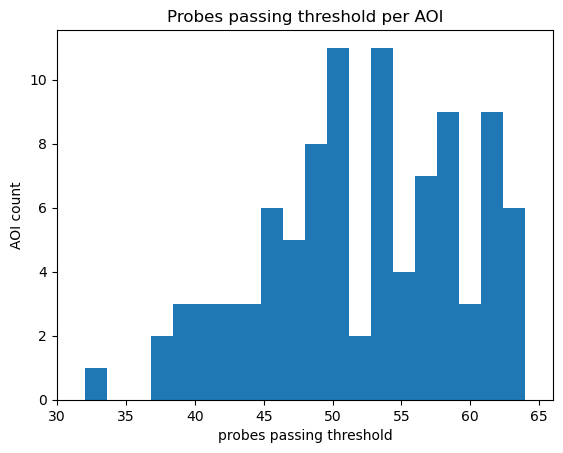

In [49]:
# get counts of how many probes are above the expression threshold for each AOI
passAOI = ETFiltered.sum()
thisMin = min(passAOI)
thisMax = max(passAOI)
print(f'thisMin :\t{thisMin}')
print(f'thisMax :\t{thisMax}')

plt.title('Probes passing threshold per AOI')
plt.xlabel('probes passing threshold')
plt.ylabel('AOI count')
plt.hist(passAOI.values, bins=20)
plt.xlim(thisMin-2,thisMax+2)
# plt.semilogy()

In [50]:
passAOI.sort_values().index[:5]

Index(['X24_008_3_4_5um_QUT_TMA1_025_TME', 'X24_008_3_4_5um_QUT_TMA1_021_TME',
       'X24_008_3_4_5um_QUT_TMA3_059_TME',
       'X24_008_3_4_5um_QUT_TMA3_025_Tumour',
       'X24_008_3_4_5um_QUT_TMA1_020_TME'],
      dtype='object')

In [51]:
failAOIs = passAOI[passAOI < 35]
failAOIs.index

Index(['X24_008_3_4_5um_QUT_TMA1_025_TME'], dtype='object')

In [52]:
sampleInfo[failAOIs.index]

X24_008_3_4_5um_QUT_TMA1_025_TME
Custom Segment Name                                  24-008_3.4-5um QUT TMA1 | 025 | TME
ROI                                                 b0da1ad5-1088-491c-967e-2bd53a4459f2
ROI (Label)                                                                          025
Segment                                             c863a473-3e92-408c-9abf-3a304d33b03f
Segment (Name/ Label)                                                                TME
ROI X Coordinate                                                         17018.908203125
ROI Y Coordinate                                                            61063.796875
Segment Tags                                                                         TME
AOI                                                                                    1
AOI surface area                                                                    9715
AOI nuclei count                                                                    92.0
Fov count                                                                            555
Fov counted                                                                          542
BindingDensity                                                                      0.29
Scan Name                                                        24-008_3.4-5um QUT TMA1
Slide                                               54bf97fa-b54a-4efa-a586-e4c1293a37a1
Scan plexset                                                                           2
Origin Instrument ID                                                           2001G0086
#Factor                                                                              NaN
Scan_ID                                                          24-008_3.4-5um QUT TMA1
ROI_ID                                                                               025
LOT_Human_Immune_Cell_Profiling_Protein_Core_1_1                               ICPH10007
LOT_Human_Immune_Activation_Status_Protein_Modu...                             IASH10003
LOT_Human_IO_Drug_Target_Protein_Module_1_1                                    DRGH10003
LOT_Human_nC_Cell_Death_Protein_1_1                                            CLDH10001
LOT_Human_Pan_Tumor_Protein_Module_1_0                                         PTRH10001
LOT_Human_PI3K_AKT_Signaling_Protein_Module_1_0                                PKSH10002
Well                                                                                 C09
Row                                                                                    C
Col                                                                                   09
Plate                                                                                  1

In [53]:
# ToDo: Move this to config file
# writeOutput = True
if writeOutput:
    failAOIs.to_csv(os.path.join(exportPath,'failAOIs.csv'))
# writeOutput= False


(1.0, 101.0)

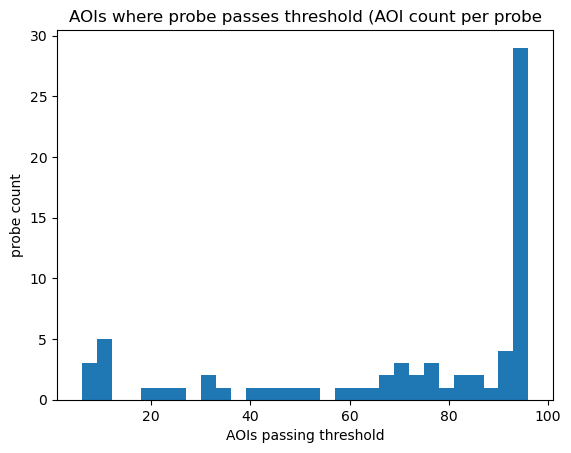

In [54]:
# plot how many AOIs are above the expression threshold for each probe

passProbe = ETFiltered.sum(axis=1)
thisMin = min(passProbe)
thisMax = max(passProbe)

plt.title('AOIs where probe passes threshold (AOI count per probe')
plt.xlabel('AOIs passing threshold')
plt.ylabel('probe count')
plt.hist(passProbe.values, bins=30)
plt.xlim(thisMin-5,thisMax+5)
# plt.semilogy()

In [55]:
# ToDo: Ask for a value to use for fail probes cutoff
# Use the group by factor function (need to finish and move to a method)

In [56]:
# ToDo: Sort this output
failProbes = passProbe[passProbe < 48]
failProbes

HYB-NEG                    10
CD80                       23
CD27                       41
PD-L2                      42
IDO1                       10
Tim-3                       8
4-1BB                      19
STING                       9
GITR                       11
OX40L                      30
VISTA                       7
B7-H3                       6
LAG3                       11
ARG1                       30
MART1                      35
Phospho-Tuberin (T1462)    24
Phospho-GSK3B (S9)         47
dtype: int64

In [57]:
failProbes = passProbe[passProbe < 100]
failProbes

CD8                        96
CD4                        96
HYB-NEG                    10
GZMB                       95
Fibronectin                96
                           ..
Phospho-Tuberin (T1462)    24
Phospho-AKT1 (S473)        83
Pan-AKT                    95
Phospho-PRAS40 (T246)      59
Phospho-GSK3B (S9)         47
Length: 71, dtype: int64

In [58]:
# ToDo: Move failProbes to config file ?

# writeOutput = True
if writeOutput:
    failProbes.to_csv(os.path.join(exportPath,'FailProbes.csv'))
# writeOutput= False


In [59]:
masterData.set_threshold(ETFiltered)

In [60]:
# masterData.threshold


# <span style="color:green"> ERCC correct data </sapan>
<div class="alert alert-block alert-success">
    ERCC correction is the first essential step in data normalisation. This step accounts for differences in hybridisation efficiency and pipetting inaccuracies.
</div>

In [61]:
erccData = masterData.ERCC_norm()
erccData, _ = masterData.add_class_mean(erccData)


Positive Control count:	1, ['HYB-POS']
Nagative Control count:	4, ['HYB-NEG', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1']
Ig Control count:	3, ['Rb IgG', 'Ms IgG2a', 'Ms IgG1']
HK Control count:	3, ['S6', 'Histone H3', 'GAPDH']
Endogenous probe count:	63, ['CD8', 'CD4', 'GZMB', 'Fibronectin', 'Beta-2-microglobulin', 'PD-1', 'HLA-DR', 'CD3', 'CD56', 'CD11c', 'CTLA4', 'CD68', 'PanCk', 'SMA', 'CD20', 'PD-L1', 'CD45', 'Ki-67', 'CD25', 'ICOS', 'CD80', 'CD27', 'PD-L2', 'CD127', 'CD40', 'CD44', 'IDO1', 'Tim-3', '4-1BB', 'STING', 'GITR', 'OX40L', 'VISTA', 'B7-H3', 'LAG3', 'ARG1', 'GZMA', 'PARP', 'CD95/Fas', 'p53', 'Cleaved Caspase 9', 'BAD', 'BCL6', 'BCLXL', 'BIM', 'PTEN', 'EpCAM', 'Her2', 'S100B', 'Bcl-2', 'NY-ESO-1', 'PR', 'MART1', 'ER-alpha', 'MET', 'INPP4B', 'PLCG1', 'Phospho-GSK3A (S21)/Phospho-GSK3B (S9)', 'Phospho-Tuberin (T1462)', 'Phospho-AKT1 (S473)', 'Pan-AKT', 'Phospho-PRAS40 (T246)', 'Phospho-GSK3B (S9)']


In [62]:
erccData

X24_008_3_4_5um_QUT_TMA3_001_Tumour  \
CD8                                                 6.855519   
CD4                                                 7.706039   
HYB-NEG                                             0.993495   
GZMB                                                7.609447   
Fibronectin                                        10.162683   
...                                                      ...   
Phospho-Tuberin (T1462)                             2.014676   
Phospho-AKT1 (S473)                                 4.218661   
Pan-AKT                                             8.538029   
Phospho-PRAS40 (T246)                               3.145115   
Phospho-GSK3B (S9)                                  1.892482   

                         X24_008_3_4_5um_QUT_TMA3_002_TME  \
CD8                                              4.698178   
CD4                                              5.178296   
HYB-NEG                                          0.658567   
GZMB                                             3.560602   
Fibronectin                                      8.808920   
...                                                   ...   
Phospho-Tuberin (T1462)                          1.672723   
Phospho-AKT1 (S473)                              2.477803   
Pan-AKT                                          5.015893   
Phospho-PRAS40 (T246)                            0.658567   
Phospho-GSK3B (S9)                               1.592017   

                         X24_008_3_4_5um_QUT_TMA3_002_Tumour  \
CD8                                                 6.390191   
CD4                                                 6.837168   
HYB-NEG                                             0.991441   
GZMB                                                5.276800   
Fibronectin                                         9.054647   
...                                                      ...   
Phospho-Tuberin (T1462)                             0.991441   
Phospho-AKT1 (S473)                                 3.863749   
Pan-AKT                                             5.710943   
Phospho-PRAS40 (T246)                               3.452599   
Phospho-GSK3B (S9)                                  3.682757   

                         X24_008_3_4_5um_QUT_TMA3_003_TME  \
CD8                                              6.999185   
CD4                                              7.677185   
HYB-NEG                                          0.000000   
GZMB                                             5.435677   
Fibronectin                                     11.520744   
...                                                   ...   
Phospho-Tuberin (T1462)                          2.510480   
Phospho-AKT1 (S473)                              3.800132   
Pan-AKT                                          5.723861   
Phospho-PRAS40 (T246)                            2.032913   
Phospho-GSK3B (S9)                               2.115925   

                         X24_008_3_4_5um_QUT_TMA3_003_Tumour  \
CD8                                                 5.189569   
CD4                                                 5.684221   
HYB-NEG                                             0.000000   
GZMB                                                4.484785   
Fibronectin                                         9.541193   
...                                                      ...   
Phospho-Tuberin (T1462)                             0.607808   
Phospho-AKT1 (S473)                                 3.363923   
Pan-AKT                                             5.707160   
Phospho-PRAS40 (T246)                               0.682233   
Phospho-GSK3B (S9)                                  2.475095   

                         X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
CD8                                                 6.315978   
CD4                                                 6.820757   
HYB-NEG                                             0.000000

# <span style="color:green"> Drop outlier AOIs and probes </sapan>
<div class="alert alert-block alert-success">
Some samples or probes may need to be dropped permanently. This can be done in the following steps.<br><br>


</div>

In [63]:
# ToDo: Add in options for interactively dropping samples.
# ToDo: read in AOIs and probes to be droped from csv files?


In [64]:
dropSamples = False
# dropSamples = True
dropSamplesTemp = []


In [65]:
# ToDo: Test this code with multiple projects

if dropSamples:
    if ('dropSamples' in configDict.keys()):
        dropSamples = configDict['dropSamples'].split(',')
        dropSamples = [x.strip() for x in dropSamples]
        dropSamples = [x.strip('\'') for x in dropSamples]
        dropSamples =pd.Index(dropSamples)



    print('dropping samples')
    erccData, sampleInfo = masterData.drop_AOIs(list(dropSamples), writeOrig=True)
    print(f'erccData.shape {erccData.shape}')
    erccData = masterData.ERCC_norm()
    erccData, sampleInfo = masterData.add_class_mean(masterData.ERCCData)

erccDataSorted = erccData.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])



In [66]:
# # # ToDo: Tidy up handling of datasets within master data. There are too many copies at the moment!
# # # ERCC correction needs to be repeated after dropping AOIs

# if (type(dropSamples) == pd.core.indexes.base.Index):
#     print('dropping samples')
#     erccData, sampleInfo = masterData.drop_AOIs(list(dropSamples), writeOrig=True)
#     print(f'erccData.shape {erccData.shape}')
#     erccData = masterData.ERCC_norm()
#     erccData, sampleInfo = masterData.add_class_mean(masterData.ERCCData)

# erccDataSorted = erccData.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])


In [67]:
if (not(type(dropSamples) == pd.core.indexes.base.Index) and (len(dropSamplesTemp) != 0)):
    print('writing drop samples to config file.')
    with open('config.txt', 'a') as config:
        config.write('dropSamples : ')
        config.write(', '.join([x for x in dropSamplesTemp]))
        config.write('\n')



# <span style="color:green"> Plot negative controls and housekeeping controls from raw data </sapan>
<div class="alert alert-block alert-success">
It's probably not neccessary to view the following, but lets just have a quick look at how the control values for the raw data is distributed to make sure there are no extreme outliers before ERCC normalisation.

</div>

In [68]:
# Calculate Ig control Geometric mean and Housekeeping gene Geometric mean
# Calculating the mean of log transformed data is analagous to calculating the geometric mean of the non-transformed data

HKGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc[masterData.HK].mean()
HKGeoMean = HKGeoMean.sort_values()

IgGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[masterData.IgCTLs].mean()

HKIgCtls = masterData.HK.copy()
HKIgCtls.extend(masterData.IgCTLs)

HKIgCtlGeoMeans = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[HKIgCtls].mean()

HKIgCtls = masterData.HK.copy()
HKIgCtls.extend(masterData.IgCTLs)

print(f'masterData.HK :\t{masterData.HK}')
print(f'HKIgCtls :\t{HKIgCtls}')
print(f'HKGeoMean :\t{HKGeoMean}')


masterData.HK :	['S6', 'Histone H3', 'GAPDH']
HKIgCtls :	['S6', 'Histone H3', 'GAPDH', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1']
HKGeoMean :	X24_008_3_4_5um_QUT_TMA1_025_TME        7.190247
X24_008_3_4_5um_QUT_TMA3_056_TME        7.669001
X24_008_3_4_5um_QUT_TMA3_025_TME        7.866714
X24_008_3_4_5um_QUT_TMA3_040_TME        7.957392
X24_008_3_4_5um_QUT_TMA3_030_TME        7.991537
                                         ...    
X24_008_3_4_5um_QUT_TMA3_006_Tumour    12.700272
X24_008_3_4_5um_QUT_TMA1_017_Tumour    12.801942
X24_008_3_4_5um_QUT_TMA1_019_Tumour    12.954207
X24_008_3_4_5um_QUT_TMA1_004_TME       13.078396
X24_008_3_4_5um_QUT_TMA1_004_Tumour    13.515424
Length: 96, dtype: float32


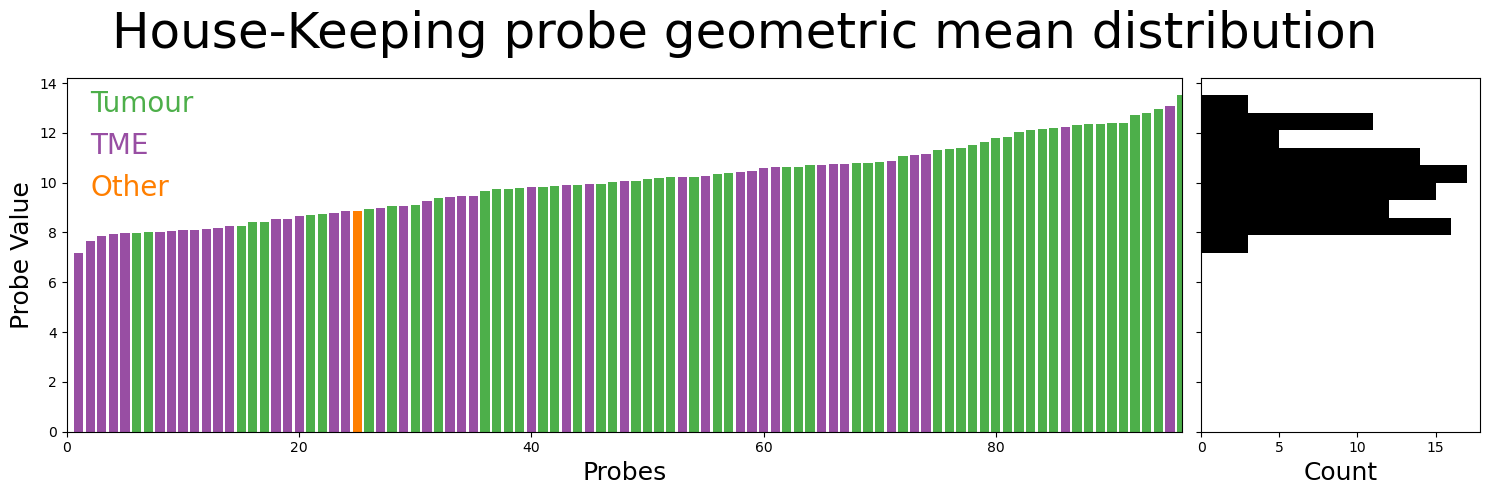

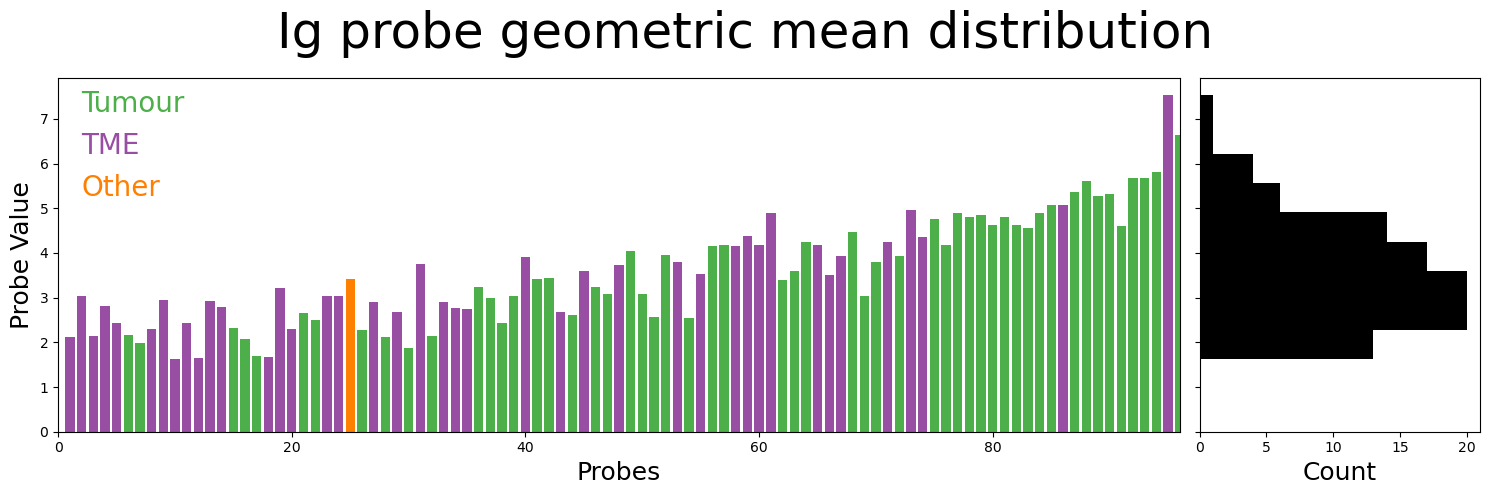

In [69]:
# ToDo: Fix up cmap for these plots. Choose a factor to colour by.

probe_GeoMean_Plots(HKGeoMean, 'House-Keeping probe geometric mean distribution')

probe_GeoMean_Plots(IgGeoMean, 'Ig probe geometric mean distribution')

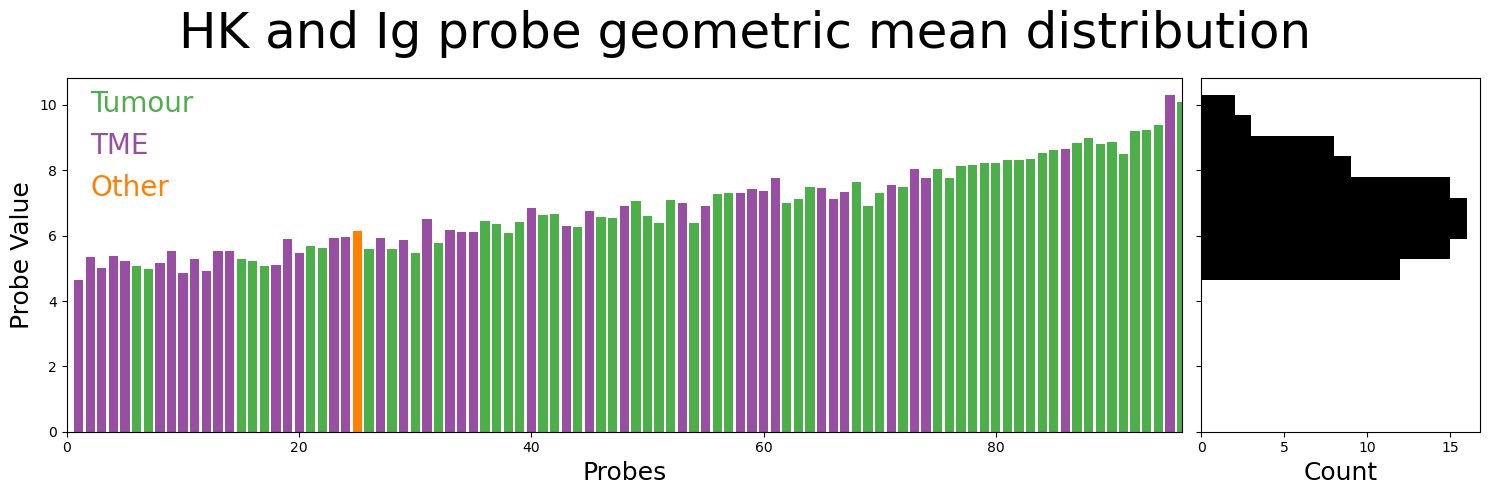

In [70]:
probe_GeoMean_Plots(HKIgCtlGeoMeans, 'HK and Ig probe geometric mean distribution')

In [71]:
HKIgCtls = masterData.HK.extend(masterData.IgCTLs)
print(f'masterData.HK :\t{masterData.HK}')


masterData.HK :	['S6', 'Histone H3', 'GAPDH', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1']



Number of unique combinations: 12


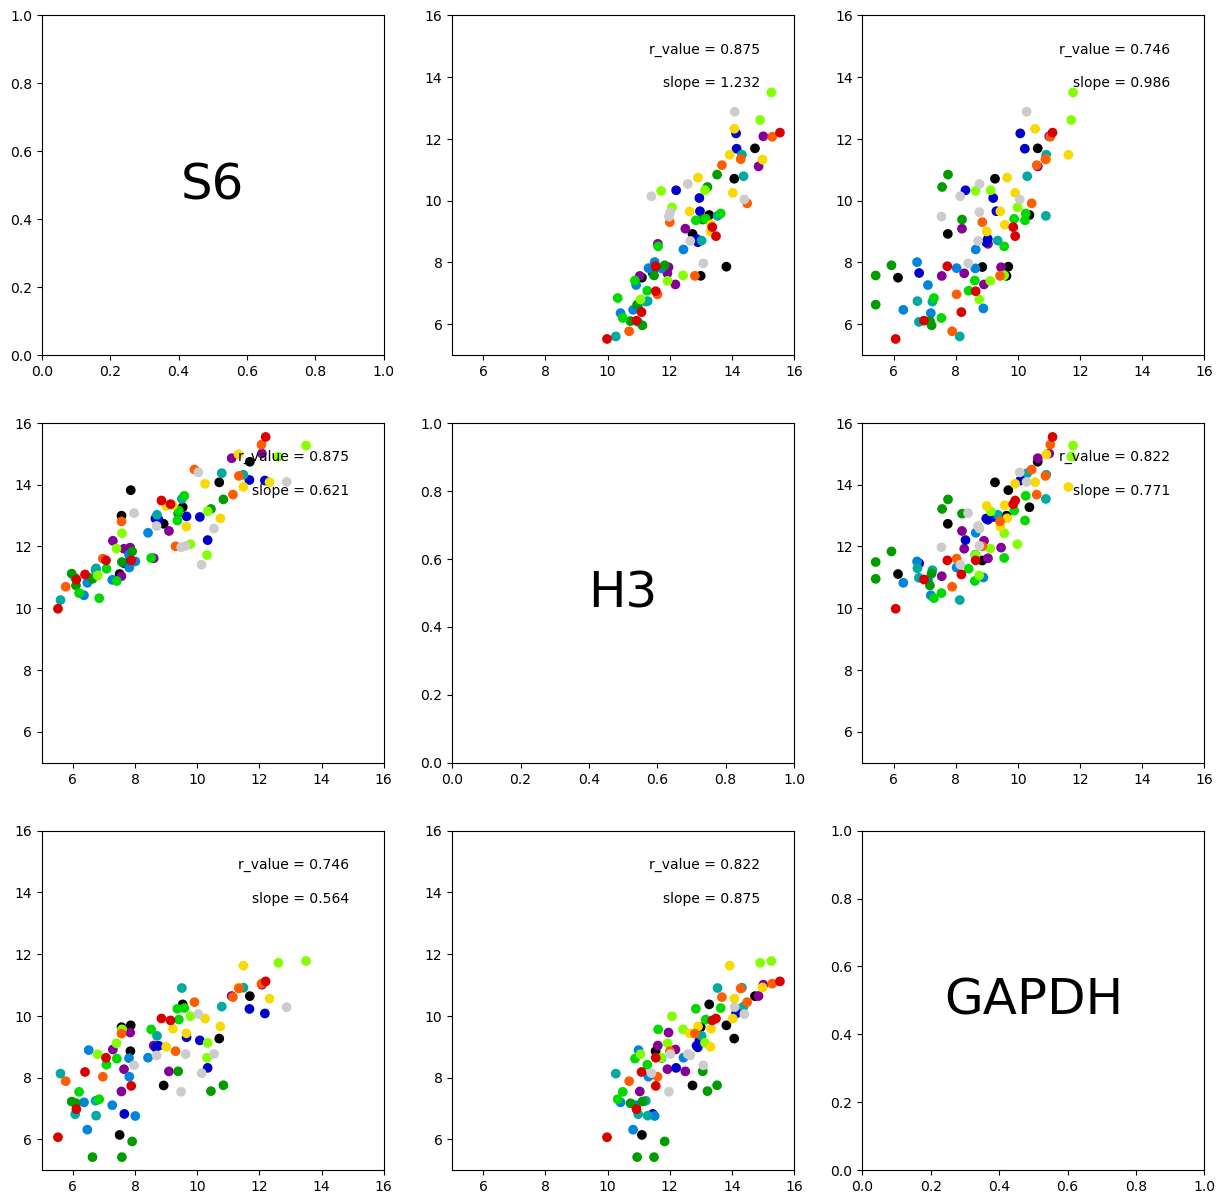

In [72]:
###
# Matrix of HK expression plots

my_cmap, colours = get_colour_mapping(sampleInfo, selectedInfo.loc['Col'])
rows = 3
cols = 3

fig, axes = plt.subplots(rows,cols, figsize=(15,15))


S6 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['S6'].values]
H3 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Histone H3'].values]
GAPDH = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['GAPDH'].values]

labels = ['S6', 'H3', 'GAPDH']
dataList = [S6, H3, GAPDH]

axMin = int(min([min(x) for x in dataList]))
axMax = int(max([max(x) for x in dataList]))+1


for r in range(rows):
    for c in range(cols):
        if r==c: # This is a diagonal, insert a label
            axes[r][c].text(0.5,0.5, labels[r],ha='center', va='center', transform=axes[r][c].transAxes,fontsize=36)
        else:
            axes[r][c].scatter(dataList[c], dataList[r], color=my_cmap(colours)) #ToDo: Add a cmap, c=colours)
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataList[c], dataList[r])
            axes[r][c].text(0.9,0.9, "r_value = " + str(r_value)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].text(0.9,0.8, "slope = " + str(slope)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].set_xlim(axMin,axMax)
            axes[r][c].set_ylim(axMin,axMax)



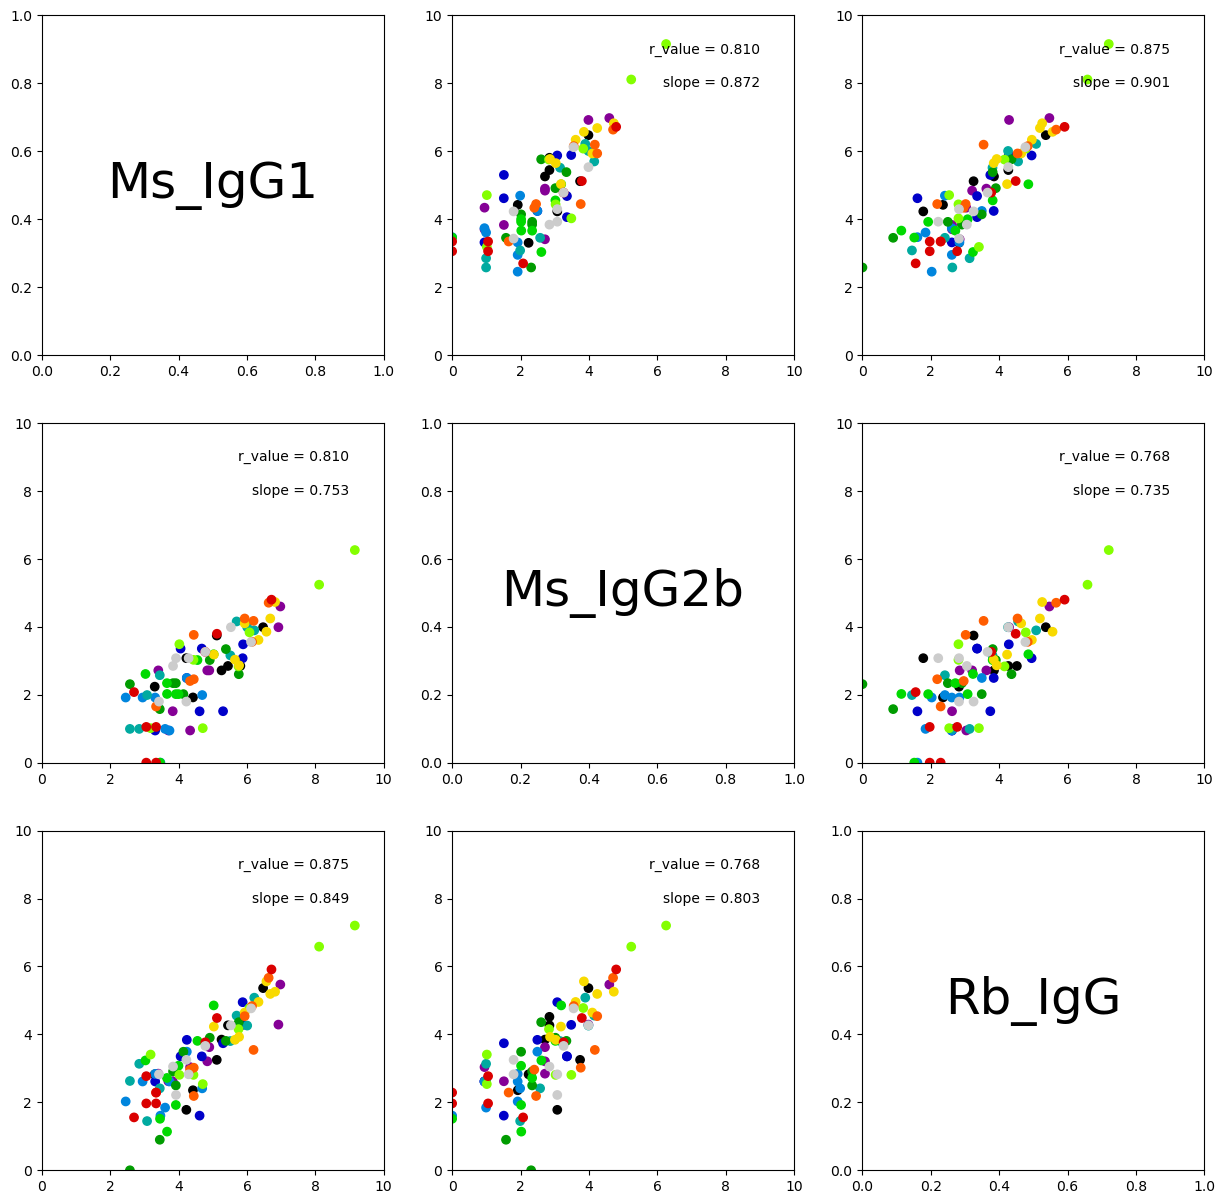

In [73]:

# Matrix of IgG expression plots
rows = 3
cols = 3

fig, axes = plt.subplots(rows,cols, figsize=(15,15))


mIG1 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Ms IgG1'].values]
mIG2 = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Ms IgG2a'].values]
rIG = [(x) for x in dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['Rb IgG'].values]

labels = ['Ms_IgG1', 'Ms_IgG2b', 'Rb_IgG']
# labels = ['Rt_IgG2a', 'Rt_IgG2b', 'Rb_IgG']
dataList = [mIG1,mIG2,rIG]

axMin = int(min([min(x) for x in dataList]))
axMax = int(max([max(x) for x in dataList]))+1


for r in range(rows):
    for c in range(cols):
        if r==c: # This is a diagonal, insert a label
            axes[r][c].text(0.5,0.5, labels[r],ha='center', va='center', transform=axes[r][c].transAxes,fontsize=36)
        else:
            axes[r][c].scatter(dataList[c], dataList[r], color=my_cmap(colours)) # ToDo: Add cmap , c=colours)
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataList[c], dataList[r])
            axes[r][c].text(0.9,0.9, "r_value = " + str(r_value)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].text(0.9,0.8, "slope = " + str(slope)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].set_xlim(axMin,axMax)
            axes[r][c].set_ylim(axMin,axMax)

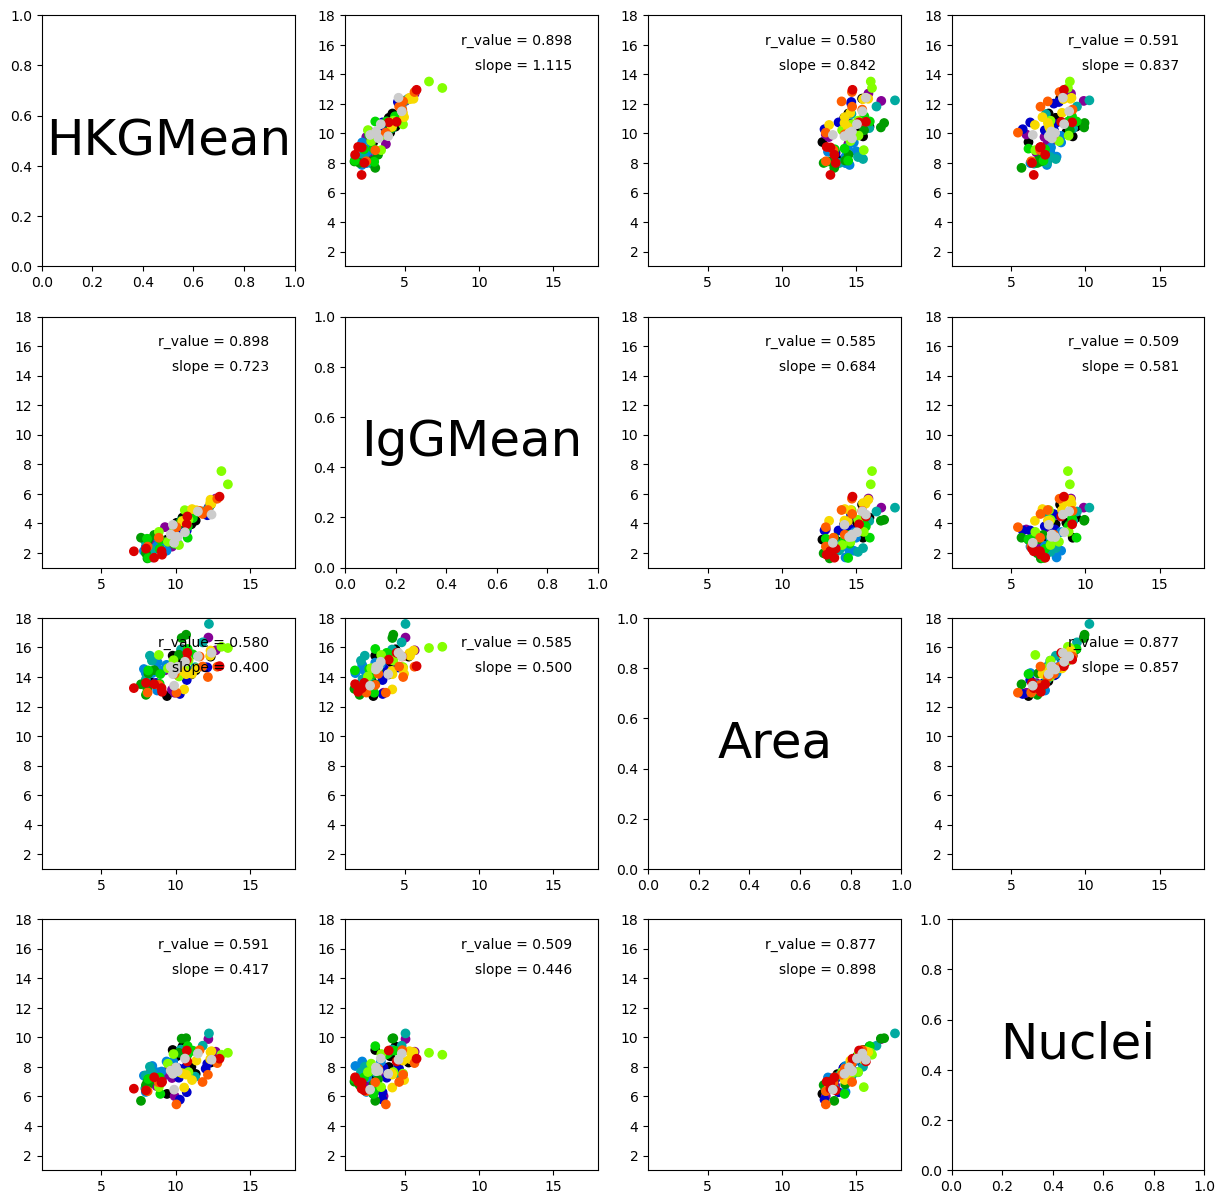

In [74]:
# Matrix of IgG expression plots
rows = 4
cols = 4

fig, axes = plt.subplots(rows,cols, figsize=(15,15))

labels = ['HKGMean', 'IgGMean', 'Area', 'Nuclei']
## Ensure HKGeoMean 
dataList = [HKGeoMean.loc[dataLog1External.columns[:-2]], 
            IgGeoMean.loc[dataLog1External.columns[:-2]], 
            np.log2(list(surfArea.values)), 
            np.log2(list(nuclei.values))]

axMin = int(min([min(x) for x in dataList]))
axMax = int(max([max(x) for x in dataList]))+1


for r in range(rows):
    for c in range(cols):
        if r==c: # This is a diagonal, insert a label
            axes[r][c].text(0.5,0.5, labels[r],ha='center', va='center', transform=axes[r][c].transAxes,fontsize=36)
        else:
            axes[r][c].scatter(dataList[c], dataList[r], color=my_cmap(colours)) # ToDo: Add cmap , c=colours)
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataList[c], dataList[r])
            axes[r][c].text(0.9,0.9, "r_value = " + str(r_value)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].text(0.9,0.8, "slope = " + str(slope)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
            axes[r][c].set_xlim(axMin,axMax)
            axes[r][c].set_ylim(axMin,axMax)
                
            

# <span style="color:green"> Load-in default QC data from DSP analysis suite for further data QC </sapan>
<div class="alert alert-block alert-success">
load in QC data from DSP analysis suite.
</div>

In [75]:
QCmasterData = master_data(os.path.join(configDict['rootDir'],configDict['QCDataPath']))
QCdataExternal, QCdataLog1External, QCsampleInfo = QCmasterData.get_data()

print(QCmasterData.probeClass)
print(QCmasterData.probeClassDict)

if (type(dropSamples) == pd.core.indexes.base.Index):
    QCdataLog1External, QCsampleInfo = QCmasterData.drop_AOIs(list(dropSamples), writeOrig=True)
    print(QCdataLog1External.shape)
    print(QCsampleInfo.shape)

QCdataLog1External, QCsampleInfo = QCmasterData.add_class_mean(QCmasterData.dataLog1)


CD8                        Endogenous
CD4                        Endogenous
GZMB                       Endogenous
Fibronectin                Endogenous
Beta-2-microglobulin       Endogenous
                              ...    
Phospho-Tuberin (T1462)    Endogenous
Phospho-AKT1 (S473)        Endogenous
Pan-AKT                    Endogenous
Phospho-PRAS40 (T246)      Endogenous
Phospho-GSK3B (S9)         Endogenous
Name: ProbeClass, Length: 69, dtype: object
{'Positive': 'A', 'Negative': 'B', 'Control': 'C', 'Endogenous': 'E'}
Positive Control count:	0, []
Nagative Control count:	3, ['Rb IgG', 'Ms IgG2a', 'Ms IgG1']
Ig Control count:	3, ['Rb IgG', 'Ms IgG2a', 'Ms IgG1']
HK Control count:	3, ['S6', 'Histone H3', 'GAPDH']
Endogenous probe count:	63, ['CD8', 'CD4', 'GZMB', 'Fibronectin', 'Beta-2-microglobulin', 'PD-1', 'HLA-DR', 'CD3', 'CD56', 'CD11c', 'CTLA4', 'CD68', 'PanCk', 'SMA', 'CD20', 'PD-L1', 'CD45', 'Ki-67', 'CD25', 'ICOS', 'CD80', 'CD27', 'PD-L2', 'CD127', 'CD40', 'CD44', 'IDO1'

/Users/upton6/anaconda3/envs/nanoeda/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [76]:
# View log transformed QC data

QCdataLog1External

X24_008_3_4_5um_QUT_TMA3_001_Tumour  \
CD8                                                 6.910950   
CD4                                                 7.761657   
GZMB                                                7.665048   
Fibronectin                                        10.218490   
Beta-2-microglobulin                                6.725991   
...                                                      ...   
Phospho-Tuberin (T1462)                             2.058524   
Phospho-AKT1 (S473)                                 4.271914   
Pan-AKT                                             8.593747   
Phospho-PRAS40 (T246)                               3.195494   
Phospho-GSK3B (S9)                                  1.935264   

                         X24_008_3_4_5um_QUT_TMA3_002_TME  \
CD8                                              4.719697   
CD4                                              5.209720   
GZMB                                             3.539359   
Fibronectin                                      8.863143   
Beta-2-microglobulin                             4.348792   
...                                                   ...   
Phospho-Tuberin (T1462)                          1.418779   
Phospho-AKT1 (S473)                              2.364732   
Pan-AKT                                          5.044335   
Phospho-PRAS40 (T246)                            1.401208   
Phospho-GSK3B (S9)                               1.318027   

                         X24_008_3_4_5um_QUT_TMA3_002_Tumour  \
CD8                                                 6.428885   
CD4                                                 6.880617   
GZMB                                                5.294544   
Fibronectin                                         9.108321   
Beta-2-microglobulin                                6.090084   
...                                                      ...   
Phospho-Tuberin (T1462)                             1.617073   
Phospho-AKT1 (S473)                                 3.814714   
Pan-AKT                                             5.738848   
Phospho-PRAS40 (T246)                               3.367016   
Phospho-GSK3B (S9)                                  3.619019   

                         X24_008_3_4_5um_QUT_TMA3_003_TME  \
CD8                                              7.055308   
CD4                                              7.733191   
GZMB                                             5.492411   
Fibronectin                                     11.576568   
Beta-2-microglobulin                             6.022718   
...                                                   ...   
Phospho-Tuberin (T1462)                          2.573293   
Phospho-AKT1 (S473)                              3.858810   
Pan-AKT                                          5.780428   
Phospho-PRAS40 (T246)                            2.098465   
Phospho-GSK3B (S9)                               2.180933   

                         X24_008_3_4_5um_QUT_TMA3_003_Tumour  \
CD8                                                 5.253452   
CD4                                                 5.745733   
GZMB                                                4.553799   
Fibronectin                                         9.597294   
Beta-2-microglobulin                                5.094914   
...                                                      ...   
Phospho-Tuberin (T1462)                             0.847754   
Phospho-AKT1 (S473)                                 3.448423   
Pan-AKT                                             5.768581   
Phospho-PRAS40 (T246)                               0.913456   
Phospho-GSK3B (S9)                                  2.583679   

                         X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
CD8                                                 6.374956   
CD4                                                 6.878773   
GZMB                                                6.069105

## <span style="color:green"> Visualise QC data before normalisation </sapan>
<div class="alert alert-block alert-success">
Check for obvious outliers etc.
</div>

In [77]:
# Sort data by probeclass then mean for nicer visualisation on plots
QCdataSortedERCC = QCdataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])



Number of unique combinations: 12

Number of unique combinations: 8


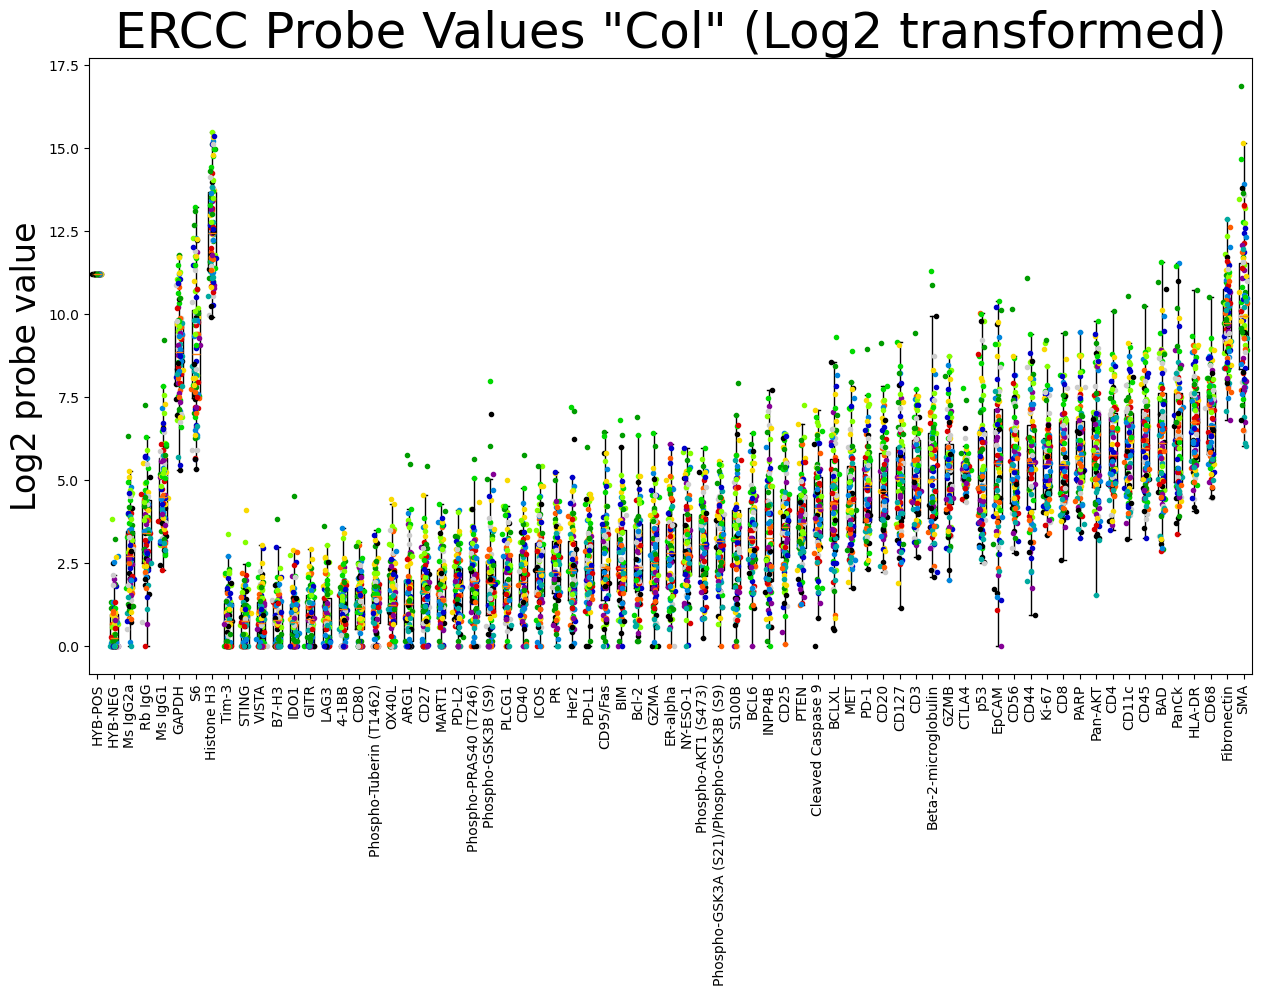

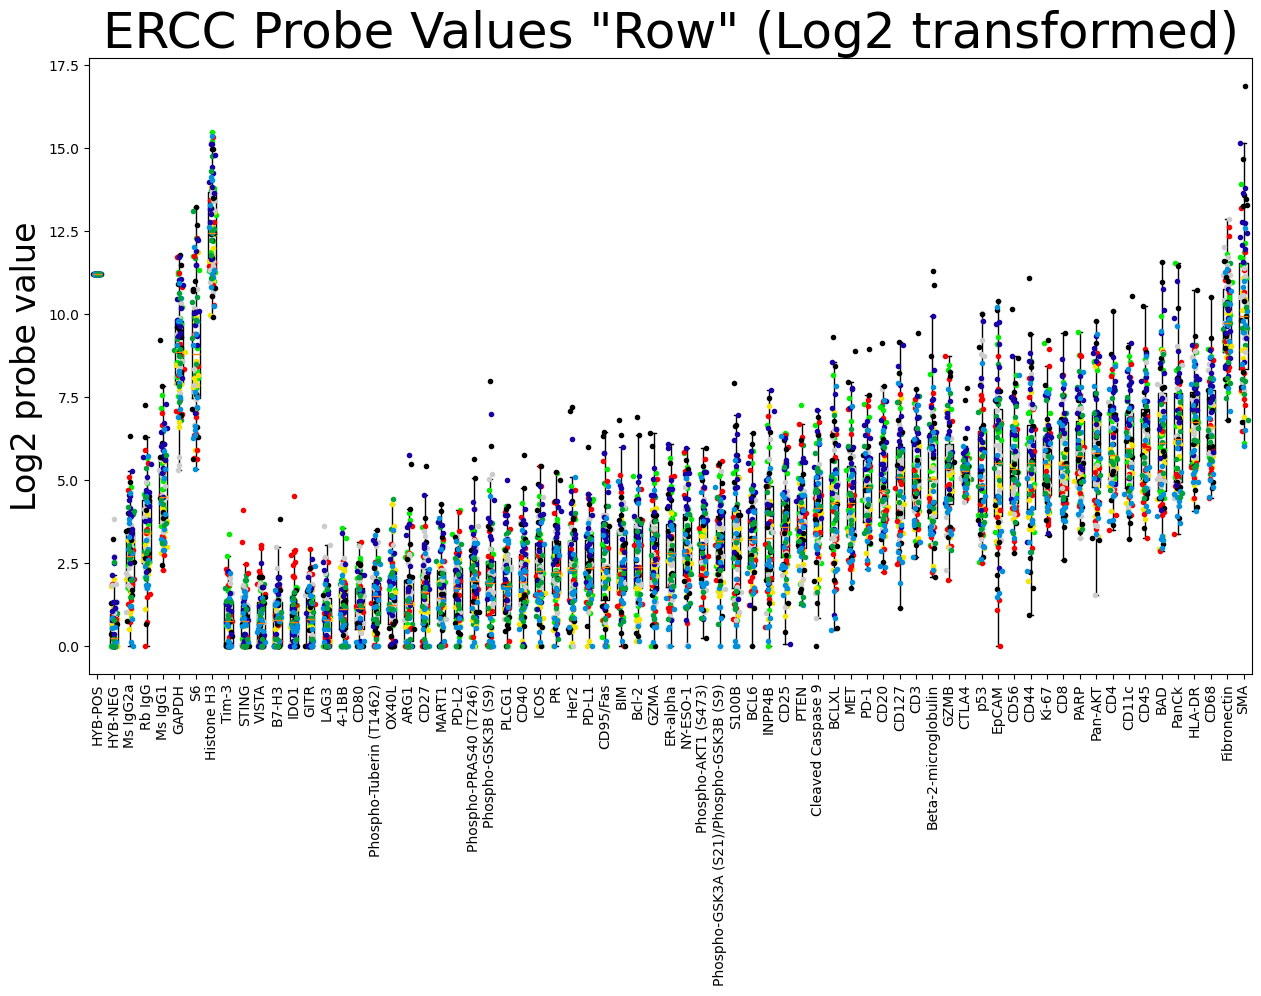

In [78]:
for s in configDict['selectedData']:
    draw_probe_plot(erccDataSorted, sampleInfo, selectedInfo, s, 'ERCC Probe Values \"' + s + '\"')
    


Number of unique combinations: 12

Number of unique combinations: 8


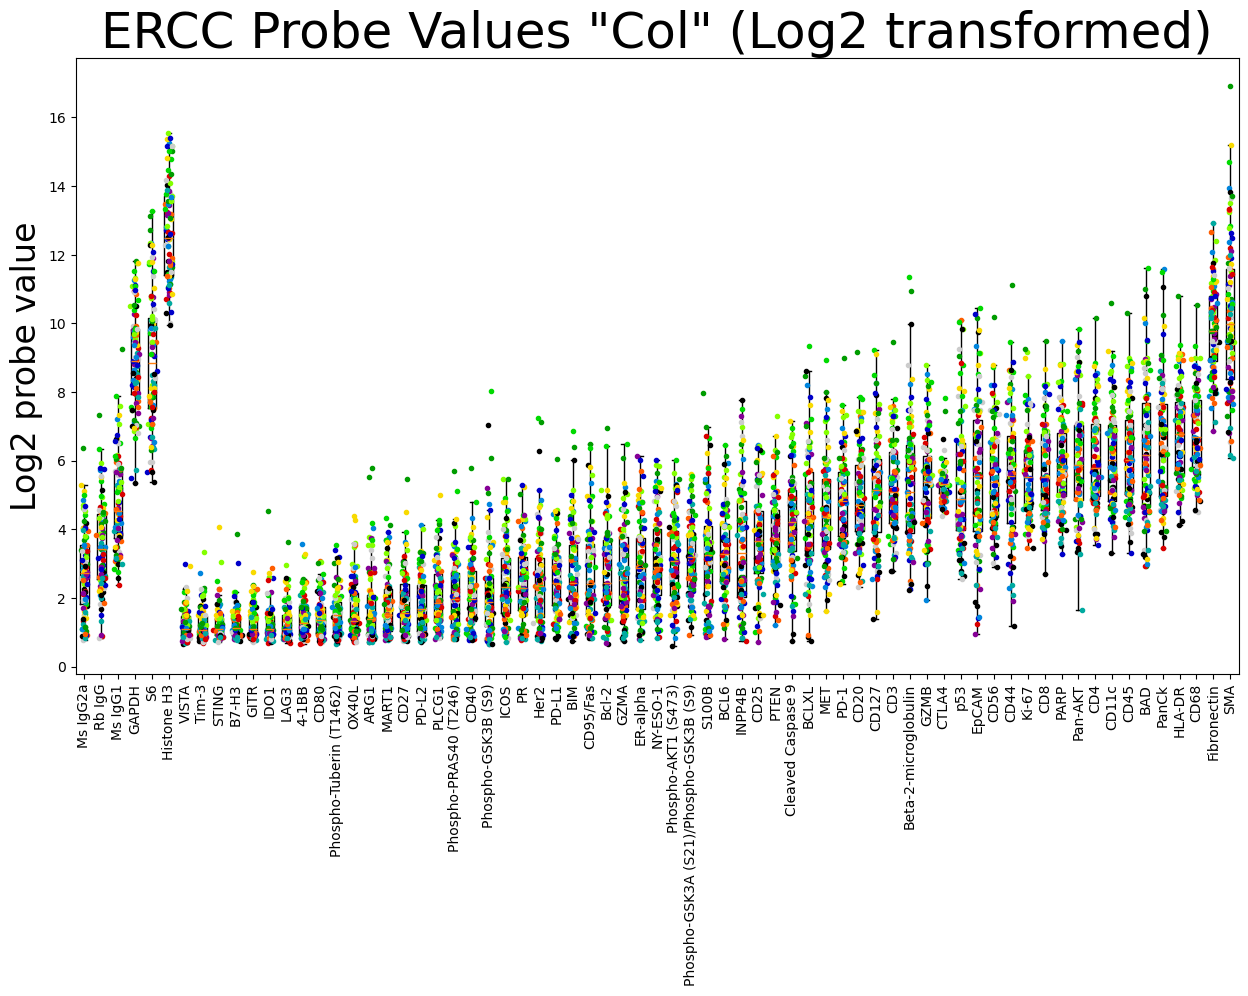

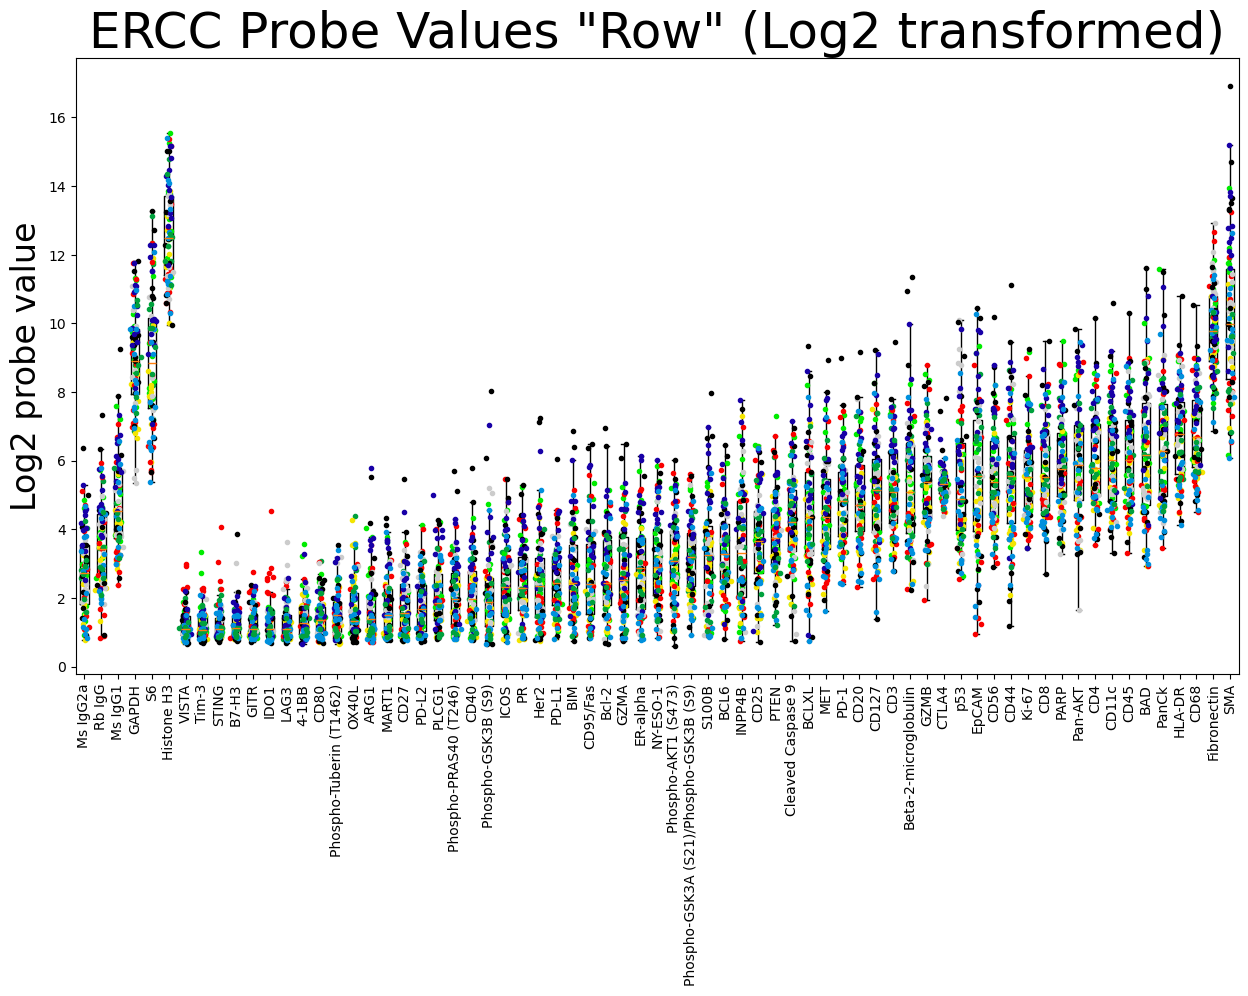

In [79]:
for s in configDict['selectedData']:
    draw_probe_plot(QCdataSortedERCC, sampleInfo, selectedInfo, s, 'ERCC Probe Values \"' + s + '\"')
    

In [80]:
QCSortedIndex = sorted(masterData.probeClass.index, key=lambda x: masterData.probeClassDict[masterData.probeClass[x]])
# QCSortedIndex
QCSortedProbes = masterData.probeClass[QCSortedIndex]
QCSortedProbes.name = "Code.Class"
QCSortedProbes

# list(QCSortedProbes.index)


HYB-POS                      Positive
HYB-NEG                      Negative
Rb IgG                       Negative
Ms IgG2a                     Negative
Ms IgG1                      Negative
                              ...    
Phospho-Tuberin (T1462)    Endogenous
Phospho-AKT1 (S473)        Endogenous
Pan-AKT                    Endogenous
Phospho-PRAS40 (T246)      Endogenous
Phospho-GSK3B (S9)         Endogenous
Name: Code.Class, Length: 71, dtype: object

In [81]:
erccData

X24_008_3_4_5um_QUT_TMA3_001_Tumour  \
CD8                                                 6.855519   
CD4                                                 7.706039   
HYB-NEG                                             0.993495   
GZMB                                                7.609447   
Fibronectin                                        10.162683   
...                                                      ...   
Phospho-Tuberin (T1462)                             2.014676   
Phospho-AKT1 (S473)                                 4.218661   
Pan-AKT                                             8.538029   
Phospho-PRAS40 (T246)                               3.145115   
Phospho-GSK3B (S9)                                  1.892482   

                         X24_008_3_4_5um_QUT_TMA3_002_TME  \
CD8                                              4.698178   
CD4                                              5.178296   
HYB-NEG                                          0.658567   
GZMB                                             3.560602   
Fibronectin                                      8.808920   
...                                                   ...   
Phospho-Tuberin (T1462)                          1.672723   
Phospho-AKT1 (S473)                              2.477803   
Pan-AKT                                          5.015893   
Phospho-PRAS40 (T246)                            0.658567   
Phospho-GSK3B (S9)                               1.592017   

                         X24_008_3_4_5um_QUT_TMA3_002_Tumour  \
CD8                                                 6.390191   
CD4                                                 6.837168   
HYB-NEG                                             0.991441   
GZMB                                                5.276800   
Fibronectin                                         9.054647   
...                                                      ...   
Phospho-Tuberin (T1462)                             0.991441   
Phospho-AKT1 (S473)                                 3.863749   
Pan-AKT                                             5.710943   
Phospho-PRAS40 (T246)                               3.452599   
Phospho-GSK3B (S9)                                  3.682757   

                         X24_008_3_4_5um_QUT_TMA3_003_TME  \
CD8                                              6.999185   
CD4                                              7.677185   
HYB-NEG                                          0.000000   
GZMB                                             5.435677   
Fibronectin                                     11.520744   
...                                                   ...   
Phospho-Tuberin (T1462)                          2.510480   
Phospho-AKT1 (S473)                              3.800132   
Pan-AKT                                          5.723861   
Phospho-PRAS40 (T246)                            2.032913   
Phospho-GSK3B (S9)                               2.115925   

                         X24_008_3_4_5um_QUT_TMA3_003_Tumour  \
CD8                                                 5.189569   
CD4                                                 5.684221   
HYB-NEG                                             0.000000   
GZMB                                                4.484785   
Fibronectin                                         9.541193   
...                                                      ...   
Phospho-Tuberin (T1462)                             0.607808   
Phospho-AKT1 (S473)                                 3.363923   
Pan-AKT                                             5.707160   
Phospho-PRAS40 (T246)                               0.682233   
Phospho-GSK3B (S9)                                  2.475095   

                         X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
CD8                                                 6.315978   
CD4                                                 6.820757   
HYB-NEG                                             0.000000

# <span style="color:green"> Export data fopr further analysis </sapan>
<div class="alert alert-block alert-success">
Text descriuption here
</div>

# <span style="color:orange"> Export ERCC corrected data </span>

<div class="alert alert-block alert-warning">
Choose whether to output manually ERCC corrected data or ERCC corrected data from DSP QC output
</div>

In [82]:
ERCCType = 'manual'
# ERCCType = 'DSP_QC'


if (ERCCType == 'manual'):
    # Export manually ERCC corrected data for further analysis
    print('manual ERCC data export')
    QCExport = erccData.sort_values(by = ['probeClass', 'mean'], ascending=[True,False])
    probeOrder = QCExport.index
    QCExport = QCExport.drop(labels=['mean','probeClass'], axis=1)
    QCExport
elif (ERCCType == 'DSP_QC'):
    # Export Nanostring QC'd ERCC corrected data for further analysis
    print('DSP QC ERCC data export')
    QCExport = QCmasterData.dataOrig.copy()
    posNeg = masterData.dataOrig.loc[['HYB-NEG','HYB-POS'],]
    QCExport = pd.concat([QCExport,posNeg])
    QCExport = QCExport.loc[QCSortedIndex,]
    QCExport = pd.concat([QCSortedProbes, QCExport], axis = 1)
    QCExport.index.name = 'Name'
    QCExport
else:
    print('ERCC correction type not valid, exiting.')
    # break


manual ERCC data export


In [83]:
# Reverse log2 transformation before normalisation
QCExport = pow(2, QCExport)

QCExport = pd.concat([QCSortedProbes, QCExport], axis = 1)
QCExport = QCExport.loc[list(probeOrder)]
QCExport.index.name = 'Name'
QCExport


Code.Class  X24_008_3_4_5um_QUT_TMA3_001_Tumour  \
Name                                                        
HYB-POS     Positive                          2340.175293   
Ms IgG1     Negative                            88.318367   
Rb IgG      Negative                            40.962685   
Ms IgG2a    Negative                            15.780657   
HYB-NEG     Negative                             1.991002   
...              ...                                  ...   
IDO1      Endogenous                             2.067240   
B7-H3     Endogenous                             1.000000   
VISTA     Endogenous                             2.207986   
STING     Endogenous                             3.380377   
Tim-3     Endogenous                             1.000000   

          X24_008_3_4_5um_QUT_TMA3_002_TME  \
Name                                         
HYB-POS                        2340.175293   
Ms IgG1                          15.564713   
Rb IgG                           11.180616   
Ms IgG2a                          7.439528   
HYB-NEG                           1.578514   
...                                    ...   
IDO1                              3.277912   
B7-H3                             1.578514   
VISTA                             1.578514   
STING                             1.578514   
Tim-3                             1.578514   

          X24_008_3_4_5um_QUT_TMA3_002_Tumour  \
Name                                            
HYB-POS                           2340.175293   
Ms IgG1                             37.219936   
Rb IgG                               6.825781   
Ms IgG2a                            16.752287   
HYB-NEG                              1.988170   
...                                       ...   
IDO1                                 1.988170   
B7-H3                                4.107736   
VISTA                                1.988170   
STING                                1.988170   
Tim-3                                4.357025   

          X24_008_3_4_5um_QUT_TMA3_003_TME  \
Name                                         
HYB-POS                        2340.175293   
Ms IgG1                          52.260921   
Rb IgG                           21.395008   
Ms IgG2a                          6.716254   
HYB-NEG                           1.000000   
...                                    ...   
IDO1                              1.940209   
B7-H3                             2.926486   
VISTA                             2.072307   
STING                             2.053493   
Tim-3                             2.047559   

          X24_008_3_4_5um_QUT_TMA3_003_Tumour  \
Name                                            
HYB-POS                           2340.175293   
Ms IgG1                             26.159107   
Rb IgG                               7.180270   
Ms IgG2a                            10.093098   
HYB-NEG                              1.000000   
...                                       ...   
IDO1                                 1.000000   
B7-H3                                1.000000   
VISTA                                1.000000   
STING                                4.369722   
Tim-3                                1.000000   

          X24_008_3_4_5um_QUT_TMA3_004_Tumour  \
Name                                            
HYB-POS                           2340.175293   
Ms IgG1                             34.030502   
Rb IgG                              15.048419   
Ms IgG2a                             5.619662   
HYB-NEG                              1.000000   
...                                       ...   
IDO1                                 1.623423   
B7-H3                                1.000000   
VISTA                                3.638306   
STING                                1.000000   
Tim-3                                1.713245   

          X24_008_3_4_5um_QUT_TMA3_005_TME  \
Name                                         
HYB-POS     

In [84]:
# check if normalisation directory exists and create it if not

normDir = os.path.join(configDict['rootDir'], 'Normalisation')
if not (os.path.isdir(normDir)):
    os.mkdir(normDir)

print(normDir)


/Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/Normalisation


In [85]:
# Write normalised data to file with _preNorm suffix

project = configDict['projectName']
qcCSV = 'QC_' + project + '_preNorm.csv'

# writeOutput= False
writeOutput = True
if writeOutput:
    QCExport.to_csv(os.path.join(normDir, qcCSV))
# writeOutput= False


# <span style="color:green"> Run NanoString Normalisation script in R </sapan>
<div class="alert alert-block alert-success">
Text descriuption here
</div>

In [86]:
cmd = 'Rscript ../DSP_EDA_Protein/NSNorm.R -d ' + normDir + ' -f ' + qcCSV
print(cmd)
os.system(cmd)


Rscript ../DSP_EDA_Protein/NSNorm.R -d /Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/Normalisation -f QC_Batra_EOI_preNorm.csv


Loading required package: matrixStats
Loading required package: ruv
Loading required package: NanoStringNorm
Loading required package: gdata

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith

Loading required package: vsn
Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:gdata’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[1] 71 98
[1] 84  3

##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 63 Endogenous genes 


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 63 Endogenous genes 


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 63 Endogenous genes 


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 63 Endogenous genes 

Background: The following samples have an estimated background greater than 
	 3 standard deviations from the mean.

                                 background.zscore
X24_008_3_4_5um_QUT_TMA1_004

0

### ToDo: Collate figures into a pdf